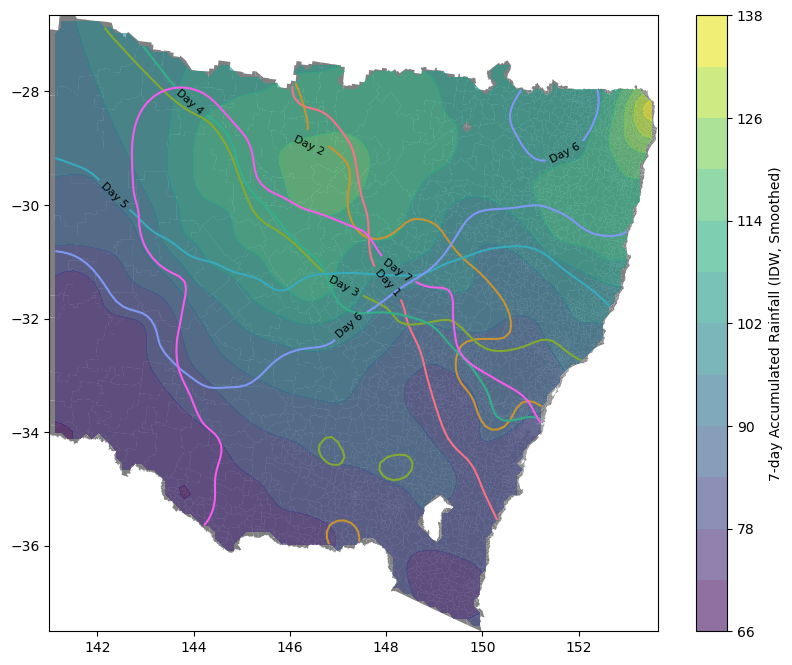

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.ndimage import gaussian_filter

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 5 - 1891-01-11 to 1891-01-17.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Extract longitude, latitude, and rainfall
longitude = x_cleaned['Longitude']
latitude = x_cleaned['Latitude']
rainfall = x_cleaned[[col for col in x_cleaned.columns if col.startswith('Rainfall')]].sum(axis=1)  # 7-day accumulated rainfall

# Initialize the interpolation grid
zi = np.zeros(xi.shape)

# IDW interpolation
for i in range(len(xi)):
    for j in range(len(yi)):
        distances = np.sqrt((longitude.values - xi[i, j])**2 + (latitude.values - yi[i, j])**2)
        weights = 1 / (distances + 1e-6)  # Avoid division by zero
        zi[i, j] = np.sum(weights * rainfall.values) / np.sum(weights)

# Apply Gaussian smoothing with a sigma of 2
zi_smoothed = gaussian_filter(zi, sigma=2)

# Mask the grid to include only points inside the shapefile geometry
points = np.vstack((xi.flatten(), yi.flatten())).T
mask = np.array([gdf.contains(Point(point)).any() for point in points])
mask = mask.reshape(xi.shape)
zi_smoothed = np.where(mask, zi_smoothed, np.nan)

# Plot the shapefile map
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='gray', edgecolor='none')

# Plot the IDW interpolated rainfall as contours
contour = ax.contourf(xi, yi, zi_smoothed, levels=10, cmap="viridis", alpha=0.6)
plt.colorbar(contour, ax=ax, label='7-day Accumulated Rainfall (IDW, Smoothed)')

# Ensure that colors array is large enough for the number of rainfall columns
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]
colors = sns.color_palette("husl", len(rainfall_columns))

for day_index, col in enumerate(rainfall_columns):
    daily_rainfall = x_cleaned[col]
    daily_zi = np.zeros(xi.shape)  # Initialize daily IDW grid

    # IDW interpolation for daily rainfall
    for row in range(len(xi)):
        for col_index in range(len(yi)):
            distances = np.sqrt((longitude.values - xi[row, col_index])**2 + (latitude.values - yi[row, col_index])**2)
            weights = 1 / (distances + 1e-6)
            daily_zi[row, col_index] = np.sum(weights * daily_rainfall.values) / np.sum(weights)

    # Apply Gaussian smoothing to daily rainfall
    daily_zi_smoothed = gaussian_filter(daily_zi, sigma=2)
    
    # Mask the daily IDW results
    daily_zi_smoothed = np.where(mask, daily_zi_smoothed, np.nan)
    
    # Choose a specific level (e.g., the mean) to plot
    specific_level = np.nanmean(daily_zi_smoothed)  # Use mean rainfall level for contour

    # Ensure that the level is valid before plotting
    if not np.isnan(specific_level):
        daily_contour = ax.contour(xi, yi, daily_zi_smoothed, levels=[specific_level], colors=[colors[day_index]], linewidths=1.5)

    # Manually add labels with custom formatting and color
    fmt = {specific_level: f'Day {day_index + 1}'}
    ax.clabel(daily_contour, fmt=fmt, inline=True, fontsize=8, colors='black')

plt.show()


In [27]:
import pandas as pd

# Define the file paths
unique_stations_file_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/BoM 3 Station list.xlsx'
lat_lon_file_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM 2 Station list.xlsx'  # Update with the actual path

# Load the Excel files
unique_stations_df = pd.read_excel(unique_stations_file_path, sheet_name='Unique Stations')
lat_lon_df = pd.read_excel(lat_lon_file_path, sheet_name='Sheet1')

# Strip any extra spaces from column names in the latitude/longitude file
lat_lon_df.columns = lat_lon_df.columns.str.strip()

# Extract the station numbers from 'Unique Station Numbers' column
station_numbers = unique_stations_df['Unique Station Numbers']

# Initialize lists to store latitudes and longitudes
latitudes = []
longitudes = []

# Loop through the station numbers and find their latitudes and longitudes in the lat/lon DataFrame
for station_number in station_numbers:
    # Find the row with the matching station number
    row = lat_lon_df[lat_lon_df['Station Number'] == station_number]
    if not row.empty:
        # Extract latitude and longitude
        lat = row['Lat'].values[0]
        lon = row['Lon'].values[0]
    else:
        # If the station number is not found, set lat and lon as None
        lat = None
        lon = None
    
    # Append to the lists
    latitudes.append(lat)
    longitudes.append(lon)

# Add the latitudes and longitudes to the 'Unique Stations' dataframe
unique_stations_df['Latitude'] = latitudes
unique_stations_df['Longitude'] = longitudes

# Save the updated dataframe back to the 'Unique Stations' sheet in the existing Excel file
with pd.ExcelWriter(unique_stations_file_path, mode='a', if_sheet_exists='replace') as writer:
    unique_stations_df.to_excel(writer, sheet_name='Unique Stations', index=False)

print("Latitudes and longitudes have been added to the 'Unique Stations' sheet.")


Latitudes and longitudes have been added to the 'Unique Stations' sheet.


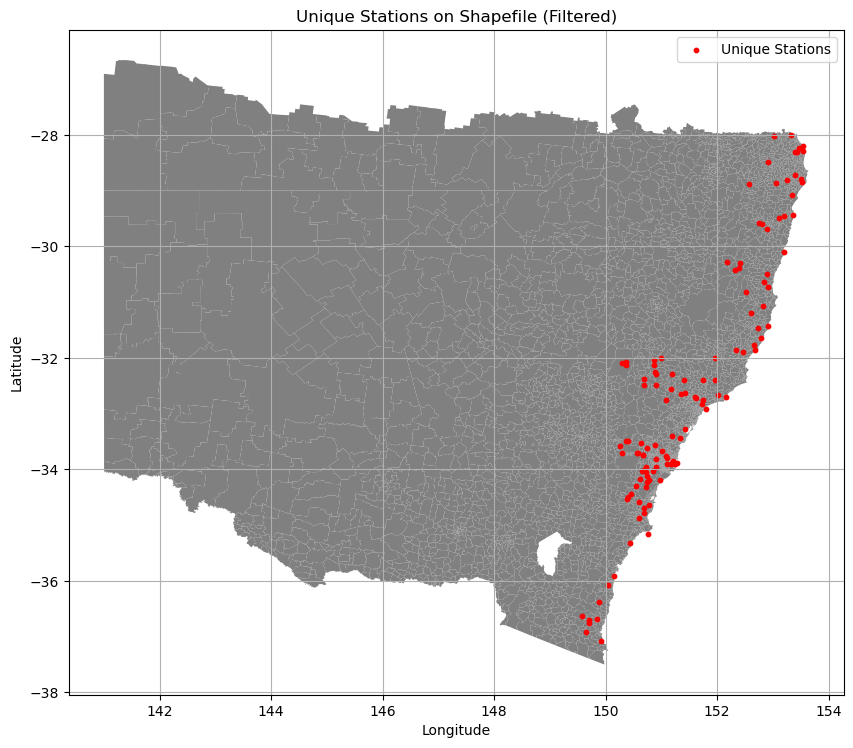

Filtered out station numbers: [42030, 44027, 41022, 44026, 44032, 44012, 44010, 44030, 43034, 44031, 41056, 41047, 41063, 44059, 44018, 41095, 41035, 41154, 41111, 41001, 41013, 44081, 41034]


In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths
unique_stations_file_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/BoM 3 Station list.xlsx'
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'

# Load the unique stations data
unique_stations_df = pd.read_excel(unique_stations_file_path, sheet_name='Unique Stations')

# Load the shapefile
shapefile = gpd.read_file(shapefile_path)

# Convert the unique stations DataFrame to a GeoDataFrame
geometry = gpd.points_from_xy(unique_stations_df['Longitude'], unique_stations_df['Latitude'])
unique_stations_gdf = gpd.GeoDataFrame(unique_stations_df, geometry=geometry)

# Define the bounds for filtering
lat_min, lat_max = -29, -28
lon_min, lon_max = 140, 152.5

# Filter out stations within the specified bounds
filtered_stations_gdf = unique_stations_gdf[
    ~((unique_stations_gdf['Latitude'] >= lat_min) & (unique_stations_gdf['Latitude'] <= lat_max) &
      (unique_stations_gdf['Longitude'] >= lon_min) & (unique_stations_gdf['Longitude'] <= lon_max))
]

# Identify the filtered out station numbers
filtered_out_station_numbers = unique_stations_gdf[
    (unique_stations_gdf['Latitude'] >= lat_min) & (unique_stations_gdf['Latitude'] <= lat_max) &
    (unique_stations_gdf['Longitude'] >= lon_min) & (unique_stations_gdf['Longitude'] <= lon_max)
]['Unique Station Numbers']

# Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
shapefile.plot(ax=ax, color='gray', edgecolor='none')

# Plot the remaining unique stations
filtered_stations_gdf.plot(ax=ax, color='red', markersize=10, label='Unique Stations')

# Add legend and titles
plt.title('Unique Stations on Shapefile (Filtered)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Print out the station numbers that were filtered out
print("Filtered out station numbers:", filtered_out_station_numbers.tolist())


In [35]:
import pandas as pd

# Define the file path
unique_stations_file_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/BoM 3 Station list.xlsx'

# Load the unique stations data
unique_stations_df = pd.read_excel(unique_stations_file_path, sheet_name='Unique Stations')

# List of station numbers to be removed
stations_to_remove = [42030, 44027, 41022, 44026, 44032, 44012, 44010, 44030,
                      43034, 44031, 41056, 41047, 41063, 44059, 44018, 41095,
                      41035, 41154, 41111, 41001, 41013, 44081, 41034]

# Remove the specified stations
filtered_unique_stations_df = unique_stations_df[~unique_stations_df['Unique Station Numbers'].isin(stations_to_remove)]

# Save the updated dataframe back to the 'Unique Stations' sheet in the Excel file
with pd.ExcelWriter(unique_stations_file_path, mode='a', if_sheet_exists='replace') as writer:
    filtered_unique_stations_df.to_excel(writer, sheet_name='Unique Stations', index=False)

print("Specified stations have been removed from the 'Unique Stations' sheet.")


Specified stations have been removed from the 'Unique Stations' sheet.


In [94]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import os
import json

# Define the file paths
unique_stations_file_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/BoM 3 Station list.xlsx'
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
output_shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/GDR_shapefile.shp'

# Load the unique stations data
unique_stations_df = pd.read_excel(unique_stations_file_path, sheet_name='Unique Stations')

# Convert the unique stations DataFrame to a GeoDataFrame
geometry = gpd.points_from_xy(unique_stations_df['Longitude'], unique_stations_df['Latitude'])
unique_stations_gdf = gpd.GeoDataFrame(unique_stations_df, geometry=geometry)

# Load the shapefile
shapefile = gpd.read_file(shapefile_path)

# Load the drawn GeoJSON file
drawn_geojson_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/data (1).geojson'
with open(drawn_geojson_path) as f:
    data = json.load(f)

# Create an empty list to hold LineStrings
lines = []

# Loop through features and create LineStrings
for feature in data['features']:
    coordinates = feature['geometry']['coordinates']
    line = LineString(coordinates)
    lines.append(line)

# Create a GeoDataFrame for the drawn borders
border_gdf = gpd.GeoDataFrame(geometry=lines, crs=shapefile.crs)

# Save the drawn borders as a new shapefile
if not os.path.exists(output_shapefile_path):
    border_gdf.to_file(output_shapefile_path)

print(f"The drawn borders have been saved as a shapefile at: {output_shapefile_path}")


The drawn borders have been saved as a shapefile at: /Users/coolkarni/Documents/Documents/Documents/Master thesis Data/GDR_shapefile.shp


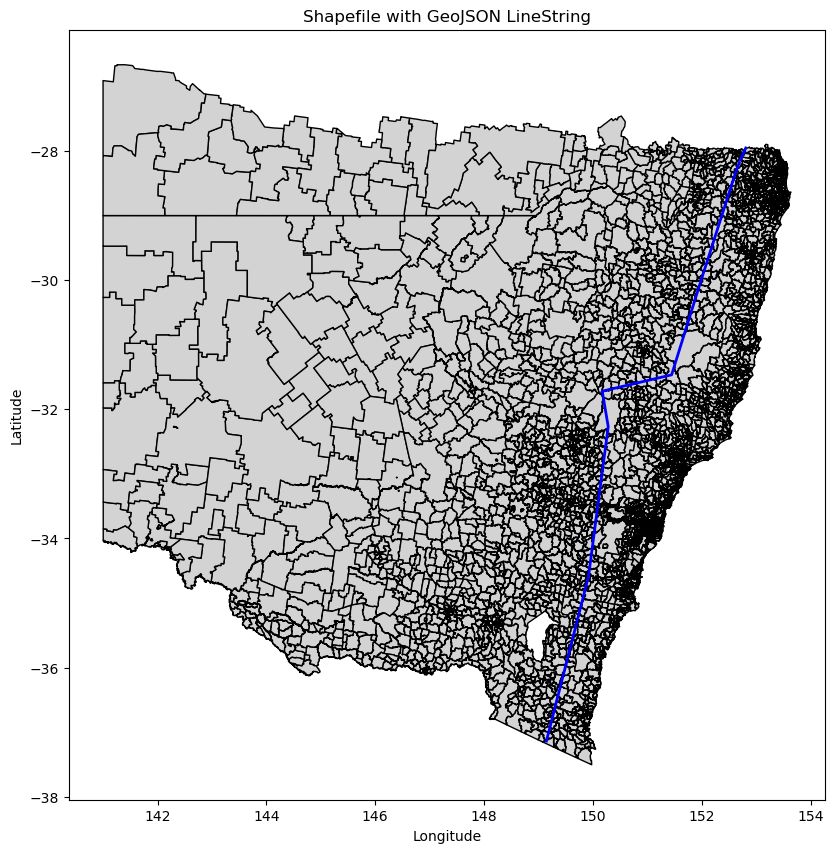

In [96]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
shapefile_data = gpd.read_file(shapefile_path)

# Load the GeoJSON file
geojson_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/data (1).geojson'
geojson_data = gpd.read_file(geojson_path)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
shapefile_data.plot(ax=ax, color='lightgrey', edgecolor='black')
geojson_data.plot(ax=ax, color='blue', linewidth=2)  # Adjust color and linewidth as needed

plt.title('Shapefile with GeoJSON LineString')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


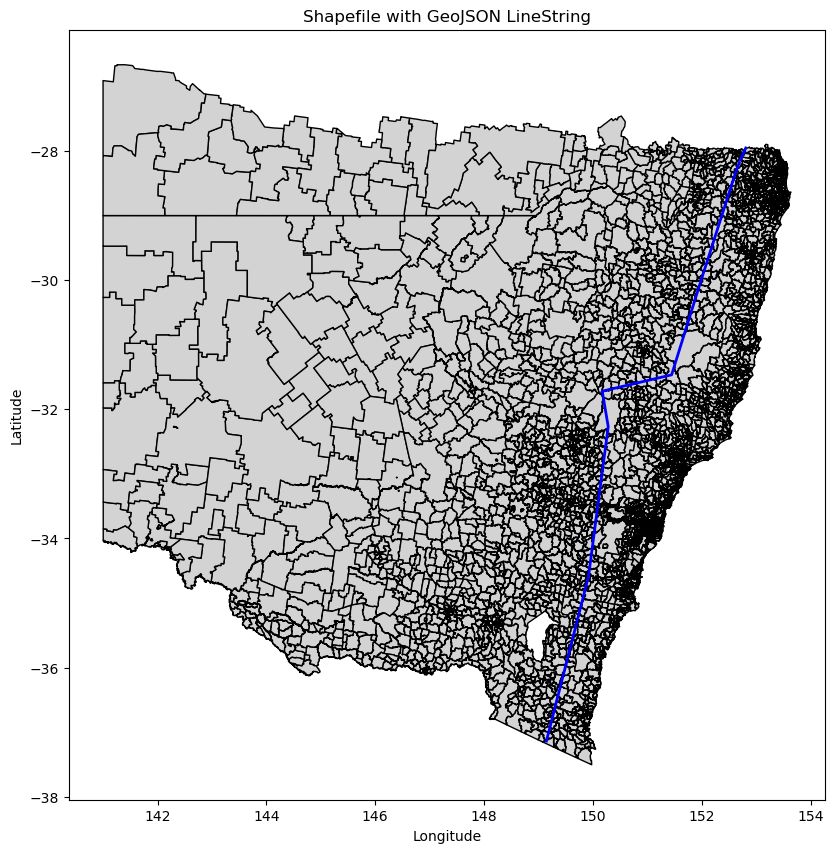

In [100]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
shapefile_data = gpd.read_file(shapefile_path)

# Load the GeoJSON file
geojson_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/data (1).geojson'
geojson_data = gpd.read_file(geojson_path)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
shapefile_data.plot(ax=ax, color='lightgrey', edgecolor='black')
geojson_data.plot(ax=ax, color='blue', linewidth=2)  # Adjust color and linewidth as needed

plt.title('Shapefile with GeoJSON LineString')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Save each layer to a GeoPackage
gpkg_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_layers.gpkg'
shapefile_data.to_file(gpkg_path, layer='polygons', driver='GPKG')
geojson_data.to_file(gpkg_path, layer='linestrings', driver='GPKG')


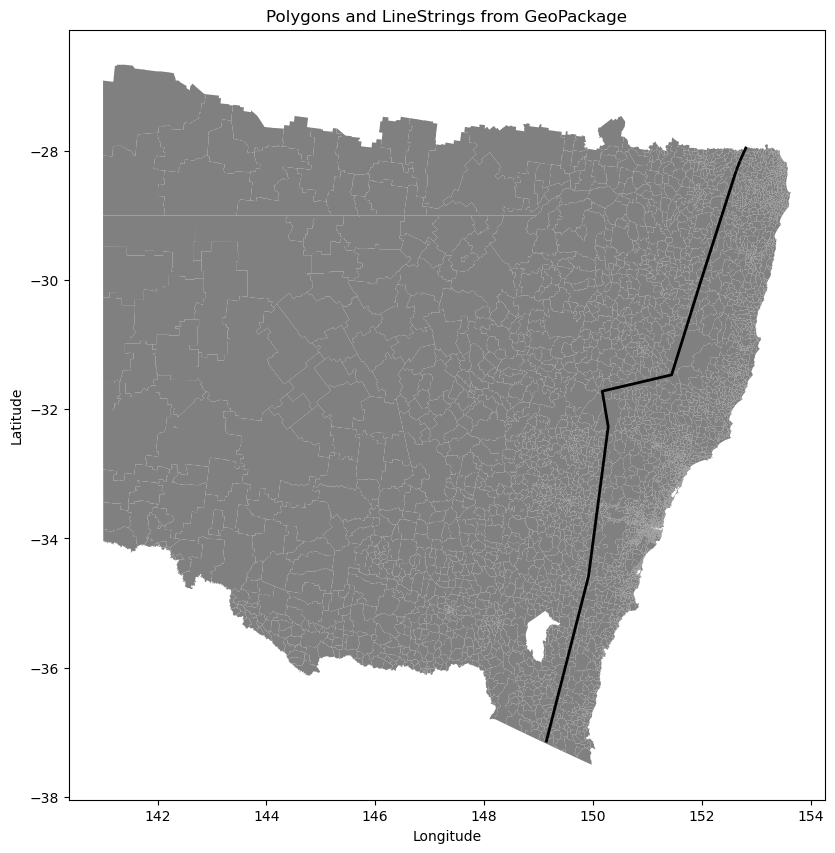

In [102]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoPackage layers
gpkg_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_layers.gpkg'
polygons_data = gpd.read_file(gpkg_path, layer='polygons')
linestrings_data = gpd.read_file(gpkg_path, layer='linestrings')

# Plotting both layers
fig, ax = plt.subplots(figsize=(10, 10))
polygons_data.plot(ax=ax, color='grey', edgecolor='none')
linestrings_data.plot(ax=ax, color='black', linewidth=2)  # Adjust color and linewidth as needed

plt.title('Polygons and LineStrings from GeoPackage')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


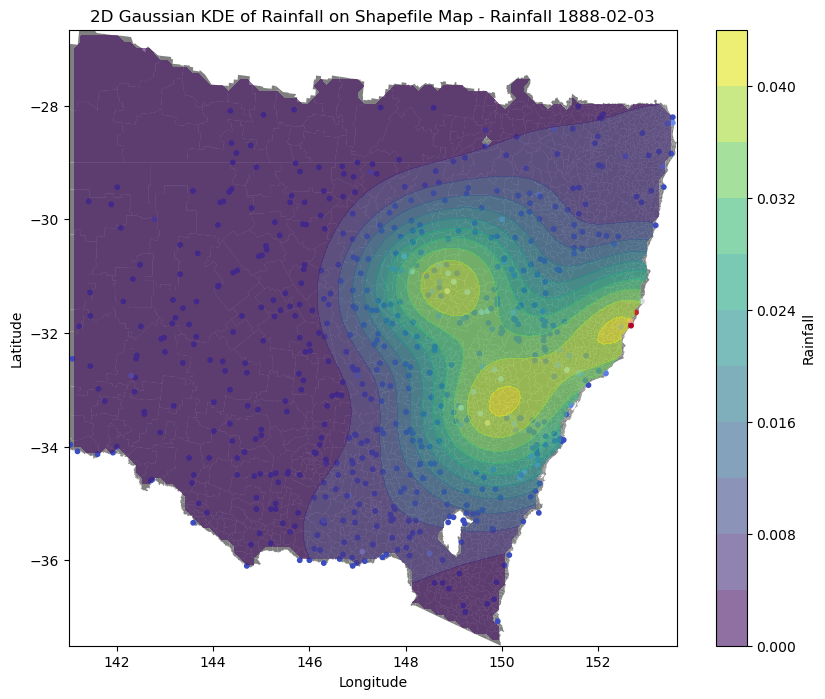

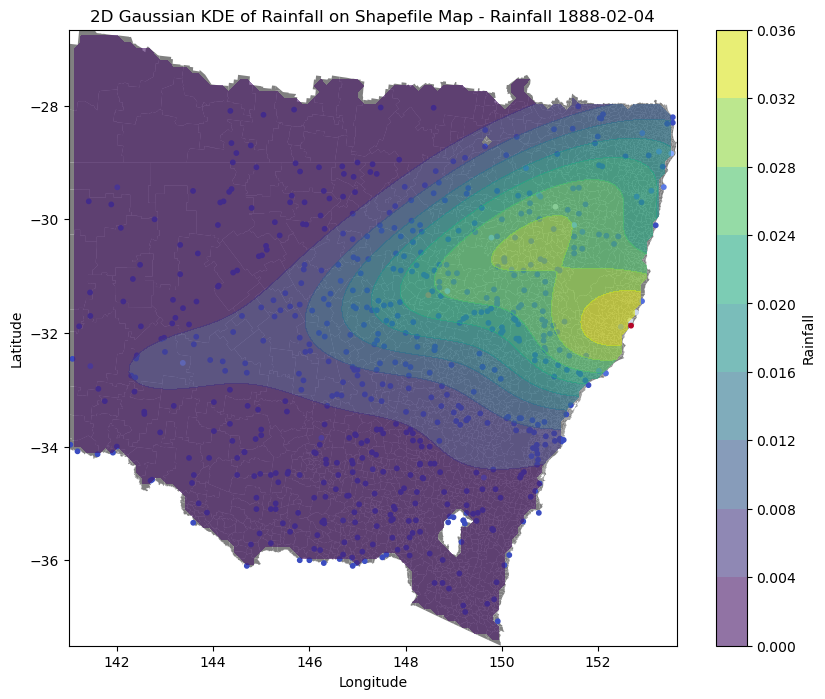

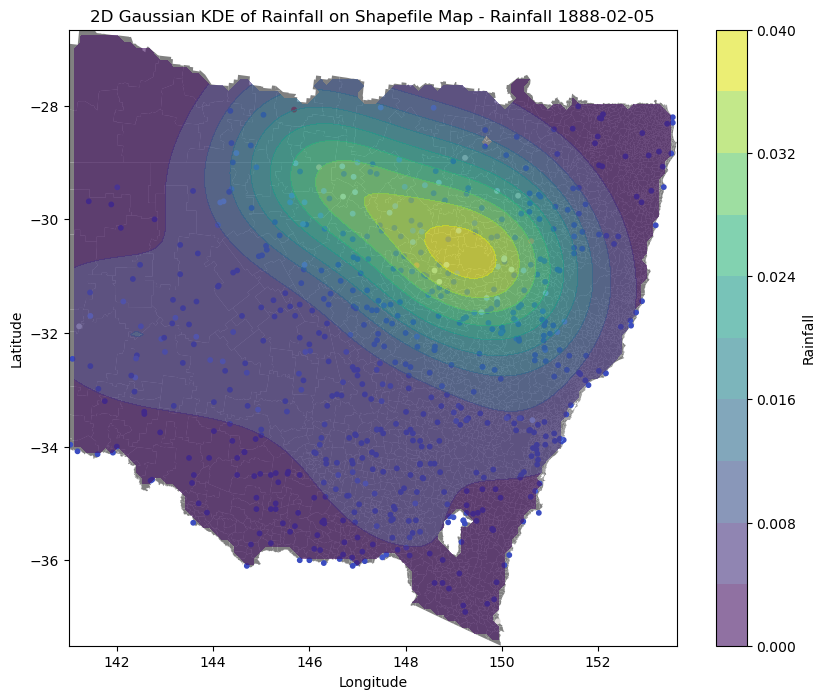

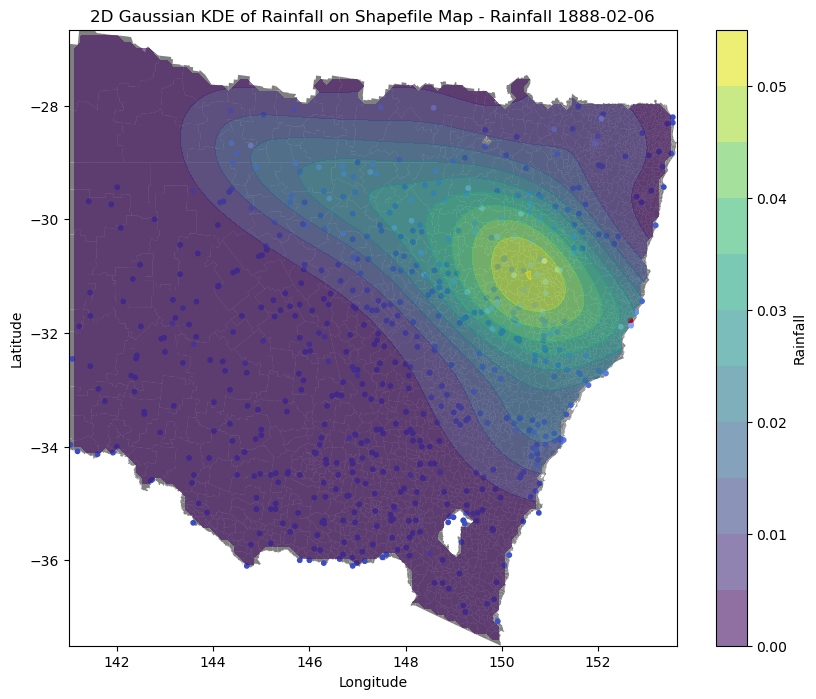

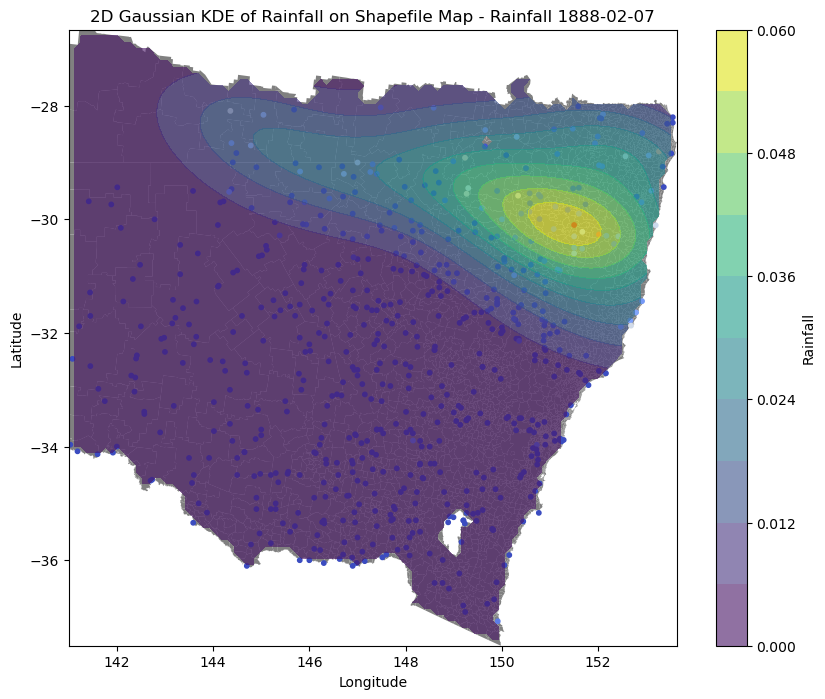

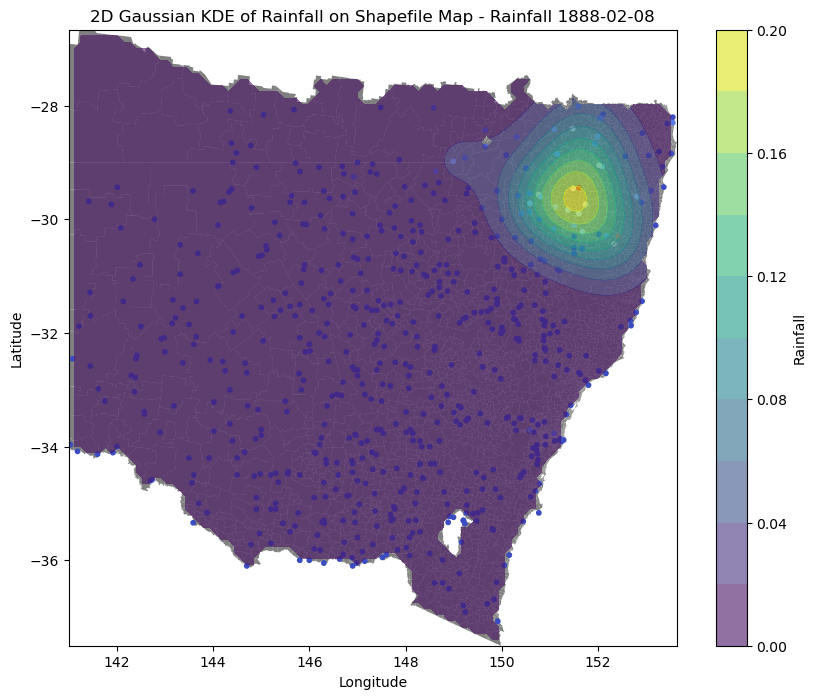

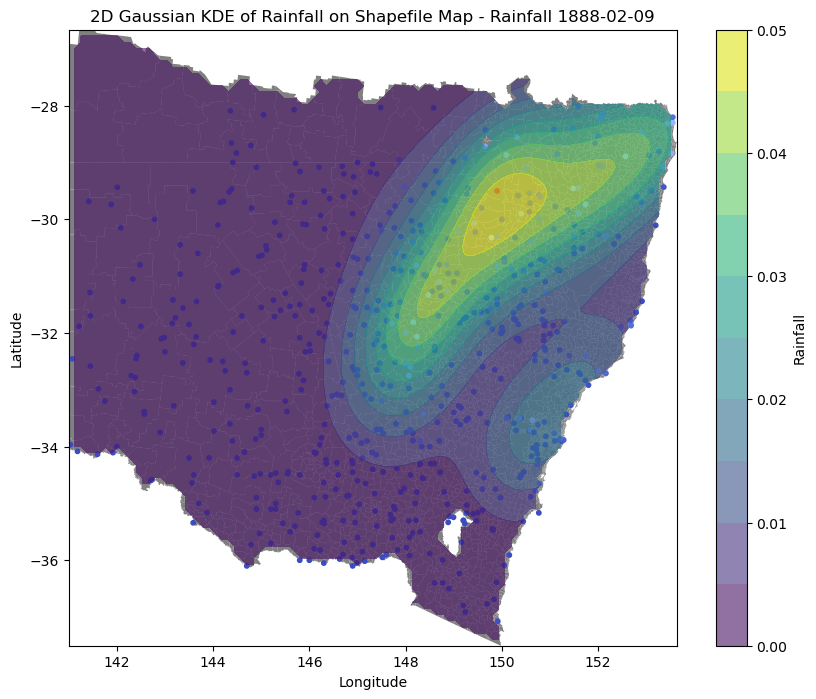

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 149 - 1888-02-03 to 1888-02-09.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for col in rainfall_columns:
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Plot the shapefile map
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color='gray', edgecolor='none')

    # Plot the 2D contour plot with rainfall as contours
    ax.scatter(x_cleaned['Longitude'], x_cleaned['Latitude'], c=rainfall, cmap='coolwarm', s=10)
    contour = ax.contourf(xi, yi, zi, levels=10, cmap="viridis", alpha=0.6)
    plt.colorbar(contour, ax=ax, label='Rainfall')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'2D Gaussian KDE of Rainfall on Shapefile Map - {col}')
    plt.show()


Day 1 Mean Rainfall: 0.57 mm
Day 2 Mean Rainfall: 0.53 mm
Day 3 Mean Rainfall: 0.88 mm
Day 4 Mean Rainfall: 1.82 mm
Day 5 Mean Rainfall: 1.87 mm
Day 6 Mean Rainfall: 1.02 mm
Day 7 Mean Rainfall: 0.17 mm
Median Threshold: 0.88 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/1151822621.py:82: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/1151822621.py:83: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]


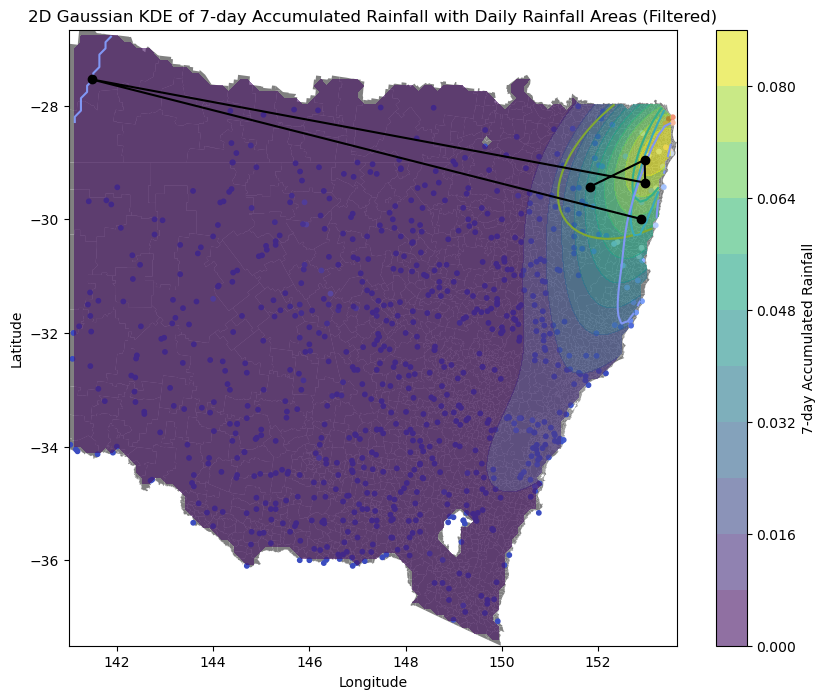

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 22 - 1898-03-04 to 1898-03-10.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Sum up the rainfall values for the 7 days
x_cleaned['7_day_accumulated_rainfall'] = x_cleaned[[col for col in x_cleaned.columns if col.startswith('Rainfall')]].sum(axis=1)

# Perform Gaussian KDE on the accumulated rainfall data
values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
rainfall = x_cleaned['7_day_accumulated_rainfall']
kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
zi = kde(positions).reshape(xi.shape)

# Mask the grid to include only points inside the shapefile geometry
points = np.vstack((xi.flatten(), yi.flatten())).T
mask = np.array([gdf.contains(Point(point)).any() for point in points])
mask = mask.reshape(xi.shape)
zi = np.where(mask, zi, np.nan)

# Plot the shapefile map
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='gray', edgecolor='none')

# Plot the 2D contour plot with accumulated rainfall as contours
ax.scatter(x_cleaned['Longitude'], x_cleaned['Latitude'], c=rainfall, cmap='coolwarm', s=10)
contour = ax.contourf(xi, yi, zi, levels=10, cmap="viridis", alpha=0.6)
plt.colorbar(contour, ax=ax, label='7-day Accumulated Rainfall')

daily_means = []  # List to store daily mean rainfall
centroids = []  # List to store retained centroids

# Perform KDE for each day and calculate centroids based on threshold
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]
colors = sns.color_palette("husl", len(rainfall_columns))

for i, col in enumerate(rainfall_columns):
    daily_rainfall = x_cleaned[col]
    daily_mean_rainfall = daily_rainfall.mean()
    daily_means.append(daily_mean_rainfall)
    print(f"Day {i+1} Mean Rainfall: {daily_mean_rainfall:.2f} mm")

# Calculate the median of the daily mean rainfall
median_threshold = np.median(daily_means)
print(f"Median Threshold: {median_threshold:.2f} mm")

for i, col in enumerate(rainfall_columns):
    daily_rainfall = x_cleaned[col]
    daily_mean_rainfall = daily_means[i]

    # Check if the daily mean exceeds the median threshold
    if daily_mean_rainfall >= median_threshold:
        daily_kde = gaussian_kde(values, weights=daily_rainfall, bw_method='scott')
        daily_zi = daily_kde(positions).reshape(xi.shape)
        daily_zi = np.where(mask, daily_zi, np.nan)
        
        daily_contour = ax.contour(xi, yi, daily_zi, levels=1, colors=[colors[i]], linewidths=1.5)

        # Calculate the centroid of the contour area
        if daily_contour.collections:
            paths = [c.get_paths() for c in daily_contour.collections]
            for path in paths:
                for p in path:
                    centroid = p.vertices.mean(axis=0)  # Calculate the centroid
                    centroids.append(centroid)

# Plot the retained centroids and connect them
if centroids:
    centroids = np.array(centroids)
    ax.plot(centroids[:, 0], centroids[:, 1], marker='o', color='black', linestyle='-', linewidth=1.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('2D Gaussian KDE of 7-day Accumulated Rainfall with Daily Rainfall Areas (Filtered)')
plt.show()


Day 1 Mean Rainfall: 1.02 mm
Day 2 Mean Rainfall: 0.45 mm
Day 3 Mean Rainfall: 2.24 mm
Day 4 Mean Rainfall: 4.43 mm
Day 5 Mean Rainfall: 2.13 mm
Day 6 Mean Rainfall: 1.68 mm
Day 7 Mean Rainfall: 3.51 mm
Median Threshold: 2.13 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_30136/1120094143.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_30136/1120094143.py:82: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_30136/1120094143.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


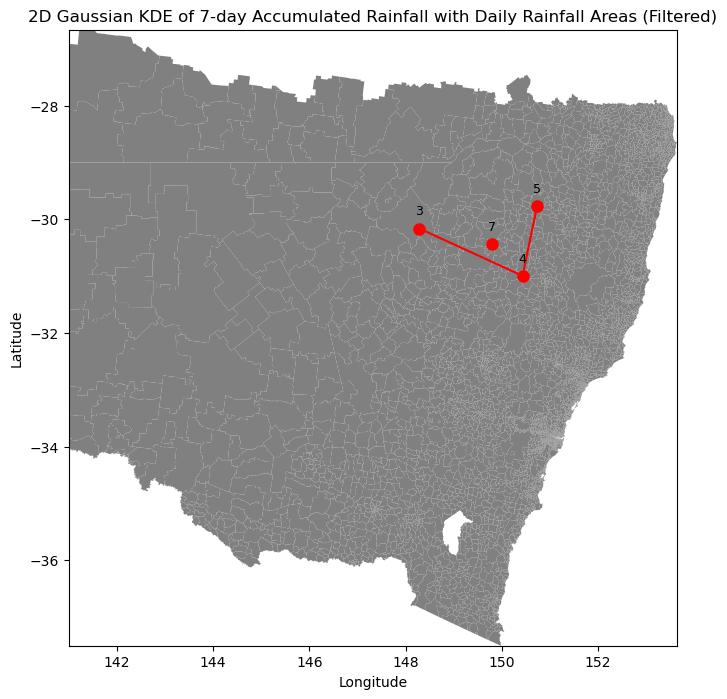

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 149 - 1888-02-03 to 1888-02-09.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Sum up the rainfall values for the 7 days
x_cleaned['7_day_accumulated_rainfall'] = x_cleaned[[col for col in x_cleaned.columns if col.startswith('Rainfall')]].sum(axis=1)

# Perform Gaussian KDE on the accumulated rainfall data
values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
rainfall = x_cleaned['7_day_accumulated_rainfall']
kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
zi = kde(positions).reshape(xi.shape)

# Mask the grid to include only points inside the shapefile geometry
points = np.vstack((xi.flatten(), yi.flatten())).T
mask = np.array([gdf.contains(Point(point)).any() for point in points])
mask = mask.reshape(xi.shape)
zi = np.where(mask, zi, np.nan)

# Plot the shapefile map
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='gray', edgecolor='none')

# Plot the 2D contour plot with accumulated rainfall as contours


daily_means = []  # List to store daily mean rainfall
centroids = []  # List to store retained centroids
retained_days = []  # List to store retained days

# Perform KDE for each day and calculate centroids based on threshold
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]
colors = sns.color_palette("husl", len(rainfall_columns))

for i, col in enumerate(rainfall_columns):
    daily_rainfall = x_cleaned[col]
    daily_mean_rainfall = daily_rainfall.mean()
    daily_means.append(daily_mean_rainfall)
    print(f"Day {i+1} Mean Rainfall: {daily_mean_rainfall:.2f} mm")

# Calculate the median of the daily mean rainfall
median_threshold = np.median(daily_means)
print(f"Median Threshold: {median_threshold:.2f} mm")

for i, col in enumerate(rainfall_columns):
    daily_rainfall = x_cleaned[col]
    daily_mean_rainfall = daily_means[i]

    # Check if the daily mean exceeds the median threshold
    if daily_mean_rainfall >= median_threshold:
        daily_kde = gaussian_kde(values, weights=daily_rainfall, bw_method='scott')
        daily_zi = daily_kde(positions).reshape(xi.shape)
        daily_zi = np.where(mask, daily_zi, np.nan)
        daily_contour = ax.contour(xi, yi, daily_zi, levels=1, colors=[colors[i]], linewidths=1.5)

        # Calculate the centroid of the contour area
        if daily_contour.collections:
            paths = [c.get_paths() for c in daily_contour.collections]
            for path in paths:
                for p in path:
                    centroid = p.vertices.mean(axis=0)  # Calculate the centroid
                    centroids.append(centroid)
                    retained_days.append(i)
        for c in daily_contour.collections:
         c.remove()  # Remove the contour lines

# Plot the retained centroids and connect them sequentially
if centroids:
    centroids = np.array(centroids)
    for j in range(len(centroids)):
        ax.plot(centroids[j, 0], centroids[j, 1], marker='o', markersize= '8',color='red', linestyle='')

        # Annotate the centroids with their respective day
        ax.annotate(f'{retained_days[j] + 1}', (centroids[j, 0], centroids[j, 1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='black')

        # Connect centroids of consecutive days
        if j > 0 and retained_days[j] == retained_days[j-1] + 1:
            ax.plot(centroids[[j-1, j], 0], centroids[[j-1, j], 1], color='red', linestyle='-', linewidth=1.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('2D Gaussian KDE of 7-day Accumulated Rainfall with Daily Rainfall Areas (Filtered)')
plt.show()


Day 1 Mean Rainfall: 0.96 mm
Day 2 Mean Rainfall: 4.75 mm
Day 3 Mean Rainfall: 4.51 mm
Day 4 Mean Rainfall: 3.30 mm
Day 5 Mean Rainfall: 0.04 mm
Day 6 Mean Rainfall: 0.09 mm
Day 7 Mean Rainfall: 1.25 mm
Median Threshold: 1.25 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_30136/2764965131.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_30136/2764965131.py:82: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_30136/2764965131.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


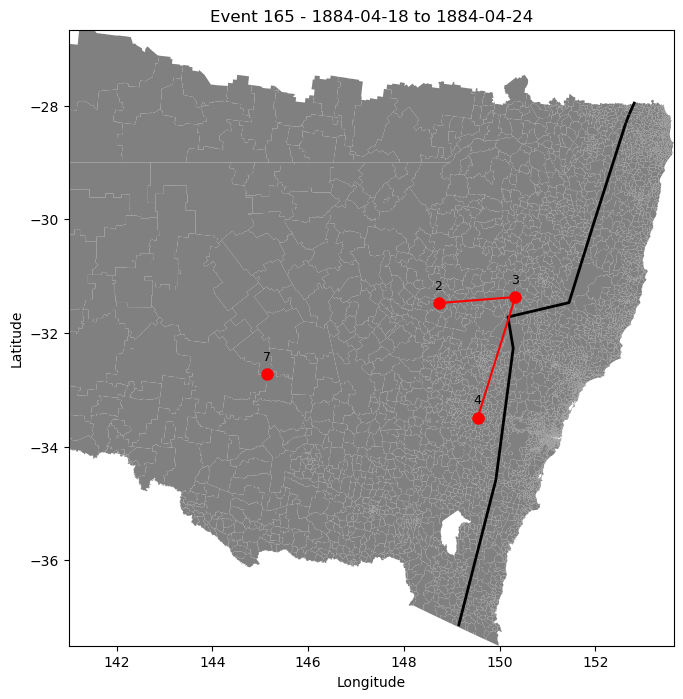

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 165 - 1884-04-18 to 1884-04-24.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Load the GeoPackage layers
gpkg_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_layers.gpkg'
polygons_data = gpd.read_file(gpkg_path, layer='polygons')  # Adjust layer name if necessary
linestrings_data = gpd.read_file(gpkg_path, layer='linestrings')  # Adjust layer name if necessary

# Get the bounds of the polygons
minx, miny, maxx, maxy = polygons_data.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Sum up the rainfall values for the 7 days
x_cleaned['7_day_accumulated_rainfall'] = x_cleaned[[col for col in x_cleaned.columns if col.startswith('Rainfall')]].sum(axis=1)

# Perform Gaussian KDE on the accumulated rainfall data
values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
rainfall = x_cleaned['7_day_accumulated_rainfall']
kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
zi = kde(positions).reshape(xi.shape)

# Mask the grid to include only points inside the polygons geometry
points = np.vstack((xi.flatten(), yi.flatten())).T
mask = np.array([polygons_data.contains(Point(point)).any() for point in points])
mask = mask.reshape(xi.shape)
zi = np.where(mask, zi, np.nan)

# Plot the polygons and linestrings
fig, ax = plt.subplots(figsize=(10, 8))
polygons_data.plot(ax=ax, color='gray', edgecolor='none')
linestrings_data.plot(ax=ax, color='black', linewidth=2)  # Adjust color and linewidth as needed

# Plot the 2D contour plot with accumulated rainfall as contours
daily_means = []  # List to store daily mean rainfall
centroids = []  # List to store retained centroids
retained_days = []  # List to store retained days

# Perform KDE for each day and calculate centroids based on threshold
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]
colors = sns.color_palette("husl", len(rainfall_columns))

for i, col in enumerate(rainfall_columns):
    daily_rainfall = x_cleaned[col]
    daily_mean_rainfall = daily_rainfall.mean()
    daily_means.append(daily_mean_rainfall)
    print(f"Day {i+1} Mean Rainfall: {daily_mean_rainfall:.2f} mm")

# Calculate the median of the daily mean rainfall
median_threshold = np.median(daily_means)
print(f"Median Threshold: {median_threshold:.2f} mm")

for i, col in enumerate(rainfall_columns):
    daily_rainfall = x_cleaned[col]
    daily_mean_rainfall = daily_means[i]

    # Check if the daily mean exceeds the median threshold
    if daily_mean_rainfall >= median_threshold:
        daily_kde = gaussian_kde(values, weights=daily_rainfall, bw_method='scott')
        daily_zi = daily_kde(positions).reshape(xi.shape)
        daily_zi = np.where(mask, daily_zi, np.nan)
        daily_contour = ax.contour(xi, yi, daily_zi, levels=1, colors=[colors[i]], linewidths=1.5)

        # Calculate the centroid of the contour area
        if daily_contour.collections:
            paths = [c.get_paths() for c in daily_contour.collections]
            for path in paths:
                for p in path:
                    centroid = p.vertices.mean(axis=0)  # Calculate the centroid
                    centroids.append(centroid)
                    retained_days.append(i)
        for c in daily_contour.collections:
            c.remove()  # Remove the contour lines

# Plot the retained centroids and connect them sequentially
if centroids:
    centroids = np.array(centroids)
    for j in range(len(centroids)):
        ax.plot(centroids[j, 0], centroids[j, 1], marker='o', markersize=8, color='red', linestyle='')

        # Annotate the centroids with their respective day
        ax.annotate(f'{retained_days[j] + 1}', (centroids[j, 0], centroids[j, 1]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, color='black')

        # Connect centroids of consecutive days
        if j > 0 and retained_days[j] == retained_days[j - 1] + 1:
            ax.plot(centroids[[j - 1, j], 0], centroids[[j - 1, j], 1], color='red', linestyle='-', linewidth=1.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Event 165 - 1884-04-18 to 1884-04-24')
plt.show()


In [2]:
import os
import shutil
import pandas as pd

# Define paths
excel_file_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/BoM Station list 4.xlsx'
source_dir = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Map_KDE_3Plots/'
target_dir = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Coastal_Events1/'

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# Load the Excel file and extract coastal event names
coastal_events_df = pd.read_excel(excel_file_path, sheet_name='Coastal Events')
coastal_event_names = coastal_events_df['Coastal Events'].dropna().unique()

# Move files corresponding to coastal events from source to target directory
for event_name in coastal_event_names:
    try:
        # Construct the file name based on the event name
        file_name = f"{event_name}.png"  # Adjust the file extension if necessary
        source_file_path = os.path.join(source_dir, file_name)
        target_file_path = os.path.join(target_dir, file_name)
        
        # Check if the file exists in the source directory
        if os.path.exists(source_file_path):
            shutil.move(source_file_path, target_file_path)
            print(f"Moved: {file_name}")
        else:
            print(f"File not found: {file_name}")
    except Exception as e:
        print(f"Error moving {event_name}: {e}")

print("File transfer complete.")


Moved: Event 3 - 1890-01-29 to 1890-02-04.png
Moved: Event 7 - 1892-03-10 to 1892-03-16.png
Moved: Event 8 - 1892-03-15 to 1892-03-21.png
Moved: Event 9 - 1892-03-30 to 1892-04-05.png
Moved: Event 10 - 1892-04-17 to 1892-04-23.png
Moved: Event 12 - 1893-01-18 to 1893-01-24.png
Moved: Event 13 - 1893-02-07 to 1893-02-13.png
Moved: Event 17 - 1894-03-11 to 1894-03-17.png
Moved: Event 19 - 1896-10-30 to 1896-11-05.png
Moved: Event 23 - 1899-07-06 to 1899-07-12.png
Moved: Event 28 - 1894-03-04 to 1894-03-10.png
Moved: Event 31 - 1895-02-05 to 1895-02-11.png
Moved: Event 32 - 1897-05-30 to 1897-06-05.png
Moved: Event 33 - 1897-12-05 to 1897-12-11.png
Moved: Event 36 - 1899-03-09 to 1899-03-15.png
Moved: Event 38 - 1900-07-02 to 1900-07-08.png
Moved: Event 43 - 1900-05-20 to 1900-05-26.png
Moved: Event 45 - 1891-02-05 to 1891-02-11.png
Moved: Event 47 - 1900-07-20 to 1900-07-26.png
Moved: Event 53 - 1898-04-29 to 1898-05-05.png
Moved: Event 54 - 1898-06-18 to 1898-06-24.png
Moved: Event 55 -

Event 550 - 1879-11-17 to 1879-11-23 - Day 1 Mean Rainfall: 0.02 mm
Event 550 - 1879-11-17 to 1879-11-23 - Day 2 Mean Rainfall: 1.77 mm
Event 550 - 1879-11-17 to 1879-11-23 - Day 3 Mean Rainfall: 7.71 mm
Event 550 - 1879-11-17 to 1879-11-23 - Day 4 Mean Rainfall: 8.34 mm
Event 550 - 1879-11-17 to 1879-11-23 - Day 5 Mean Rainfall: 0.03 mm
Event 550 - 1879-11-17 to 1879-11-23 - Day 6 Mean Rainfall: 0.02 mm
Event 550 - 1879-11-17 to 1879-11-23 - Day 7 Mean Rainfall: 0.27 mm
Event 550 - 1879-11-17 to 1879-11-23 - Median Threshold: 0.27 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 552 - 1884-07-18 to 1884-07-24 - Day 1 Mean Rainfall: 0.04 mm
Event 552 - 1884-07-18 to 1884-07-24 - Day 2 Mean Rainfall: 0.01 mm
Event 552 - 1884-07-18 to 1884-07-24 - Day 3 Mean Rainfall: 0.03 mm
Event 552 - 1884-07-18 to 1884-07-24 - Day 4 Mean Rainfall: 0.65 mm
Event 552 - 1884-07-18 to 1884-07-24 - Day 5 Mean Rainfall: 2.39 mm
Event 552 - 1884-07-18 to 1884-07-24 - Day 6 Mean Rainfall: 2.05 mm
Event 552 - 1884-07-18 to 1884-07-24 - Day 7 Mean Rainfall: 1.31 mm
Event 552 - 1884-07-18 to 1884-07-24 - Median Threshold: 0.65 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 553 - 1881-09-07 to 1881-09-13 - Day 1 Mean Rainfall: 0.13 mm
Event 553 - 1881-09-07 to 1881-09-13 - Day 2 Mean Rainfall: 0.18 mm
Event 553 - 1881-09-07 to 1881-09-13 - Day 3 Mean Rainfall: 0.09 mm
Event 553 - 1881-09-07 to 1881-09-13 - Day 4 Mean Rainfall: 5.96 mm
Event 553 - 1881-09-07 to 1881-09-13 - Day 5 Mean Rainfall: 12.71 mm
Event 553 - 1881-09-07 to 1881-09-13 - Day 6 Mean Rainfall: 7.10 mm
Event 553 - 1881-09-07 to 1881-09-13 - Day 7 Mean Rainfall: 2.63 mm
Event 553 - 1881-09-07 to 1881-09-13 - Median Threshold: 2.63 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 554 - 1887-12-28 to 1888-01-03 - Day 1 Mean Rainfall: 3.55 mm
Event 554 - 1887-12-28 to 1888-01-03 - Day 2 Mean Rainfall: 4.68 mm
Event 554 - 1887-12-28 to 1888-01-03 - Day 3 Mean Rainfall: 7.06 mm
Event 554 - 1887-12-28 to 1888-01-03 - Day 4 Mean Rainfall: 4.06 mm
Event 554 - 1887-12-28 to 1888-01-03 - Day 5 Mean Rainfall: 2.83 mm
Event 554 - 1887-12-28 to 1888-01-03 - Day 6 Mean Rainfall: 3.08 mm
Event 554 - 1887-12-28 to 1888-01-03 - Day 7 Mean Rainfall: 3.73 mm
Event 554 - 1887-12-28 to 1888-01-03 - Median Threshold: 3.73 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 555 - 1889-10-03 to 1889-10-09 - Day 1 Mean Rainfall: 0.01 mm
Event 555 - 1889-10-03 to 1889-10-09 - Day 2 Mean Rainfall: 0.31 mm
Event 555 - 1889-10-03 to 1889-10-09 - Day 3 Mean Rainfall: 2.67 mm
Event 555 - 1889-10-03 to 1889-10-09 - Day 4 Mean Rainfall: 12.01 mm
Event 555 - 1889-10-03 to 1889-10-09 - Day 5 Mean Rainfall: 12.91 mm
Event 555 - 1889-10-03 to 1889-10-09 - Day 6 Mean Rainfall: 0.16 mm
Event 555 - 1889-10-03 to 1889-10-09 - Day 7 Mean Rainfall: 0.05 mm
Event 555 - 1889-10-03 to 1889-10-09 - Median Threshold: 0.31 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 556 - 1890-05-15 to 1890-05-21 - Day 1 Mean Rainfall: 1.21 mm
Event 556 - 1890-05-15 to 1890-05-21 - Day 2 Mean Rainfall: 4.57 mm
Event 556 - 1890-05-15 to 1890-05-21 - Day 3 Mean Rainfall: 9.43 mm
Event 556 - 1890-05-15 to 1890-05-21 - Day 4 Mean Rainfall: 8.24 mm
Event 556 - 1890-05-15 to 1890-05-21 - Day 5 Mean Rainfall: 3.16 mm
Event 556 - 1890-05-15 to 1890-05-21 - Day 6 Mean Rainfall: 0.28 mm
Event 556 - 1890-05-15 to 1890-05-21 - Day 7 Mean Rainfall: 0.19 mm
Event 556 - 1890-05-15 to 1890-05-21 - Median Threshold: 3.16 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 559 - 1878-09-07 to 1878-09-13 - Day 1 Mean Rainfall: 0.92 mm
Event 559 - 1878-09-07 to 1878-09-13 - Day 2 Mean Rainfall: 0.86 mm
Event 559 - 1878-09-07 to 1878-09-13 - Day 3 Mean Rainfall: 6.95 mm
Event 559 - 1878-09-07 to 1878-09-13 - Day 4 Mean Rainfall: 11.82 mm
Event 559 - 1878-09-07 to 1878-09-13 - Day 5 Mean Rainfall: 6.53 mm
Event 559 - 1878-09-07 to 1878-09-13 - Day 6 Mean Rainfall: 2.07 mm
Event 559 - 1878-09-07 to 1878-09-13 - Day 7 Mean Rainfall: 1.19 mm
Event 559 - 1878-09-07 to 1878-09-13 - Median Threshold: 2.07 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 560 - 1880-03-20 to 1880-03-26 - Day 1 Mean Rainfall: 0.62 mm
Event 560 - 1880-03-20 to 1880-03-26 - Day 2 Mean Rainfall: 2.11 mm
Event 560 - 1880-03-20 to 1880-03-26 - Day 3 Mean Rainfall: 3.22 mm
Event 560 - 1880-03-20 to 1880-03-26 - Day 4 Mean Rainfall: 4.33 mm
Event 560 - 1880-03-20 to 1880-03-26 - Day 5 Mean Rainfall: 3.60 mm
Event 560 - 1880-03-20 to 1880-03-26 - Day 6 Mean Rainfall: 6.49 mm
Event 560 - 1880-03-20 to 1880-03-26 - Day 7 Mean Rainfall: 2.59 mm
Event 560 - 1880-03-20 to 1880-03-26 - Median Threshold: 3.22 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 561 - 1892-09-09 to 1892-09-15 - Day 1 Mean Rainfall: 0.13 mm
Event 561 - 1892-09-09 to 1892-09-15 - Day 2 Mean Rainfall: 1.23 mm
Event 561 - 1892-09-09 to 1892-09-15 - Day 3 Mean Rainfall: 2.18 mm
Event 561 - 1892-09-09 to 1892-09-15 - Day 4 Mean Rainfall: 1.66 mm
Event 561 - 1892-09-09 to 1892-09-15 - Day 5 Mean Rainfall: 1.18 mm
Event 561 - 1892-09-09 to 1892-09-15 - Day 6 Mean Rainfall: 1.18 mm
Event 561 - 1892-09-09 to 1892-09-15 - Day 7 Mean Rainfall: 2.49 mm
Event 561 - 1892-09-09 to 1892-09-15 - Median Threshold: 1.23 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 562 - 1896-11-22 to 1896-11-28 - Day 1 Mean Rainfall: 0.69 mm
Event 562 - 1896-11-22 to 1896-11-28 - Day 2 Mean Rainfall: 0.74 mm
Event 562 - 1896-11-22 to 1896-11-28 - Day 3 Mean Rainfall: 2.19 mm
Event 562 - 1896-11-22 to 1896-11-28 - Day 4 Mean Rainfall: 4.93 mm
Event 562 - 1896-11-22 to 1896-11-28 - Day 5 Mean Rainfall: 2.26 mm
Event 562 - 1896-11-22 to 1896-11-28 - Day 6 Mean Rainfall: 3.76 mm
Event 562 - 1896-11-22 to 1896-11-28 - Day 7 Mean Rainfall: 3.99 mm
Event 562 - 1896-11-22 to 1896-11-28 - Median Threshold: 2.26 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 564 - 1899-01-09 to 1899-01-15 - Day 1 Mean Rainfall: 0.06 mm
Event 564 - 1899-01-09 to 1899-01-15 - Day 2 Mean Rainfall: 0.37 mm
Event 564 - 1899-01-09 to 1899-01-15 - Day 3 Mean Rainfall: 2.43 mm
Event 564 - 1899-01-09 to 1899-01-15 - Day 4 Mean Rainfall: 3.28 mm
Event 564 - 1899-01-09 to 1899-01-15 - Day 5 Mean Rainfall: 0.27 mm
Event 564 - 1899-01-09 to 1899-01-15 - Day 6 Mean Rainfall: 0.07 mm
Event 564 - 1899-01-09 to 1899-01-15 - Day 7 Mean Rainfall: 0.02 mm
Event 564 - 1899-01-09 to 1899-01-15 - Median Threshold: 0.27 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 565 - 1884-04-22 to 1884-04-28 - Day 1 Mean Rainfall: 0.04 mm
Event 565 - 1884-04-22 to 1884-04-28 - Day 2 Mean Rainfall: 0.09 mm
Event 565 - 1884-04-22 to 1884-04-28 - Day 3 Mean Rainfall: 1.25 mm
Event 565 - 1884-04-22 to 1884-04-28 - Day 4 Mean Rainfall: 11.32 mm
Event 565 - 1884-04-22 to 1884-04-28 - Day 5 Mean Rainfall: 7.80 mm
Event 565 - 1884-04-22 to 1884-04-28 - Day 6 Mean Rainfall: 0.30 mm
Event 565 - 1884-04-22 to 1884-04-28 - Day 7 Mean Rainfall: 0.51 mm
Event 565 - 1884-04-22 to 1884-04-28 - Median Threshold: 0.51 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 566 - 1890-02-27 to 1890-03-05 - Day 1 Mean Rainfall: 2.03 mm
Event 566 - 1890-02-27 to 1890-03-05 - Day 2 Mean Rainfall: 3.12 mm
Event 566 - 1890-02-27 to 1890-03-05 - Day 3 Mean Rainfall: 4.12 mm
Event 566 - 1890-02-27 to 1890-03-05 - Day 4 Mean Rainfall: 3.17 mm
Event 566 - 1890-02-27 to 1890-03-05 - Day 5 Mean Rainfall: 4.40 mm
Event 566 - 1890-02-27 to 1890-03-05 - Day 6 Mean Rainfall: 4.13 mm
Event 566 - 1890-02-27 to 1890-03-05 - Day 7 Mean Rainfall: 2.67 mm
Event 566 - 1890-02-27 to 1890-03-05 - Median Threshold: 3.17 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 567 - 1883-03-17 to 1883-03-23 - Day 1 Mean Rainfall: 0.00 mm
Event 567 - 1883-03-17 to 1883-03-23 - Day 2 Mean Rainfall: 0.06 mm
Event 567 - 1883-03-17 to 1883-03-23 - Day 3 Mean Rainfall: 0.75 mm
Event 567 - 1883-03-17 to 1883-03-23 - Day 4 Mean Rainfall: 3.28 mm
Event 567 - 1883-03-17 to 1883-03-23 - Day 5 Mean Rainfall: 1.85 mm
Event 567 - 1883-03-17 to 1883-03-23 - Day 6 Mean Rainfall: 1.52 mm
Event 567 - 1883-03-17 to 1883-03-23 - Day 7 Mean Rainfall: 1.53 mm
Event 567 - 1883-03-17 to 1883-03-23 - Median Threshold: 1.52 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 568 - 1887-04-02 to 1887-04-08 - Day 1 Mean Rainfall: 2.02 mm
Event 568 - 1887-04-02 to 1887-04-08 - Day 2 Mean Rainfall: 2.58 mm
Event 568 - 1887-04-02 to 1887-04-08 - Day 3 Mean Rainfall: 3.75 mm
Event 568 - 1887-04-02 to 1887-04-08 - Day 4 Mean Rainfall: 5.28 mm
Event 568 - 1887-04-02 to 1887-04-08 - Day 5 Mean Rainfall: 3.05 mm
Event 568 - 1887-04-02 to 1887-04-08 - Day 6 Mean Rainfall: 1.53 mm
Event 568 - 1887-04-02 to 1887-04-08 - Day 7 Mean Rainfall: 1.32 mm
Event 568 - 1887-04-02 to 1887-04-08 - Median Threshold: 2.58 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 569 - 1881-03-25 to 1881-03-31 - Day 1 Mean Rainfall: 2.74 mm
Event 569 - 1881-03-25 to 1881-03-31 - Day 2 Mean Rainfall: 2.04 mm
Event 569 - 1881-03-25 to 1881-03-31 - Day 3 Mean Rainfall: 3.87 mm
Event 569 - 1881-03-25 to 1881-03-31 - Day 4 Mean Rainfall: 15.36 mm
Event 569 - 1881-03-25 to 1881-03-31 - Day 5 Mean Rainfall: 16.50 mm
Event 569 - 1881-03-25 to 1881-03-31 - Day 6 Mean Rainfall: 5.28 mm
Event 569 - 1881-03-25 to 1881-03-31 - Day 7 Mean Rainfall: 0.43 mm
Event 569 - 1881-03-25 to 1881-03-31 - Median Threshold: 3.87 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 570 - 1887-03-17 to 1887-03-23 - Day 1 Mean Rainfall: 3.59 mm
Event 570 - 1887-03-17 to 1887-03-23 - Day 2 Mean Rainfall: 5.88 mm
Event 570 - 1887-03-17 to 1887-03-23 - Day 3 Mean Rainfall: 10.67 mm
Event 570 - 1887-03-17 to 1887-03-23 - Day 4 Mean Rainfall: 13.87 mm
Event 570 - 1887-03-17 to 1887-03-23 - Day 5 Mean Rainfall: 9.69 mm
Event 570 - 1887-03-17 to 1887-03-23 - Day 6 Mean Rainfall: 4.57 mm
Event 570 - 1887-03-17 to 1887-03-23 - Day 7 Mean Rainfall: 2.00 mm
Event 570 - 1887-03-17 to 1887-03-23 - Median Threshold: 5.88 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 571 - 1894-01-03 to 1894-01-09 - Day 1 Mean Rainfall: 1.12 mm
Event 571 - 1894-01-03 to 1894-01-09 - Day 2 Mean Rainfall: 2.10 mm
Event 571 - 1894-01-03 to 1894-01-09 - Day 3 Mean Rainfall: 4.84 mm
Event 571 - 1894-01-03 to 1894-01-09 - Day 4 Mean Rainfall: 9.79 mm
Event 571 - 1894-01-03 to 1894-01-09 - Day 5 Mean Rainfall: 2.27 mm
Event 571 - 1894-01-03 to 1894-01-09 - Day 6 Mean Rainfall: 2.61 mm
Event 571 - 1894-01-03 to 1894-01-09 - Day 7 Mean Rainfall: 3.28 mm
Event 571 - 1894-01-03 to 1894-01-09 - Median Threshold: 2.61 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 573 - 1893-11-06 to 1893-11-12 - Day 1 Mean Rainfall: 0.29 mm
Event 573 - 1893-11-06 to 1893-11-12 - Day 2 Mean Rainfall: 1.10 mm
Event 573 - 1893-11-06 to 1893-11-12 - Day 3 Mean Rainfall: 3.06 mm
Event 573 - 1893-11-06 to 1893-11-12 - Day 4 Mean Rainfall: 12.69 mm
Event 573 - 1893-11-06 to 1893-11-12 - Day 5 Mean Rainfall: 7.09 mm
Event 573 - 1893-11-06 to 1893-11-12 - Day 6 Mean Rainfall: 3.88 mm
Event 573 - 1893-11-06 to 1893-11-12 - Day 7 Mean Rainfall: 11.55 mm
Event 573 - 1893-11-06 to 1893-11-12 - Median Threshold: 3.88 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 574 - 1898-10-19 to 1898-10-25 - Day 1 Mean Rainfall: 0.32 mm
Event 574 - 1898-10-19 to 1898-10-25 - Day 2 Mean Rainfall: 1.87 mm
Event 574 - 1898-10-19 to 1898-10-25 - Day 3 Mean Rainfall: 8.64 mm
Event 574 - 1898-10-19 to 1898-10-25 - Day 4 Mean Rainfall: 9.63 mm
Event 574 - 1898-10-19 to 1898-10-25 - Day 5 Mean Rainfall: 0.40 mm
Event 574 - 1898-10-19 to 1898-10-25 - Day 6 Mean Rainfall: 0.09 mm
Event 574 - 1898-10-19 to 1898-10-25 - Day 7 Mean Rainfall: 0.04 mm
Event 574 - 1898-10-19 to 1898-10-25 - Median Threshold: 0.40 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 575 - 1890-04-08 to 1890-04-14 - Day 1 Mean Rainfall: 1.27 mm
Event 575 - 1890-04-08 to 1890-04-14 - Day 2 Mean Rainfall: 4.35 mm
Event 575 - 1890-04-08 to 1890-04-14 - Day 3 Mean Rainfall: 8.39 mm
Event 575 - 1890-04-08 to 1890-04-14 - Day 4 Mean Rainfall: 7.58 mm
Event 575 - 1890-04-08 to 1890-04-14 - Day 5 Mean Rainfall: 0.31 mm
Event 575 - 1890-04-08 to 1890-04-14 - Day 6 Mean Rainfall: 0.03 mm
Event 575 - 1890-04-08 to 1890-04-14 - Day 7 Mean Rainfall: 0.11 mm
Event 575 - 1890-04-08 to 1890-04-14 - Median Threshold: 1.27 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 576 - 1891-01-27 to 1891-02-02 - Day 1 Mean Rainfall: 1.09 mm
Event 576 - 1891-01-27 to 1891-02-02 - Day 2 Mean Rainfall: 1.19 mm
Event 576 - 1891-01-27 to 1891-02-02 - Day 3 Mean Rainfall: 1.39 mm
Event 576 - 1891-01-27 to 1891-02-02 - Day 4 Mean Rainfall: 3.06 mm
Event 576 - 1891-01-27 to 1891-02-02 - Day 5 Mean Rainfall: 3.01 mm
Event 576 - 1891-01-27 to 1891-02-02 - Day 6 Mean Rainfall: 0.76 mm
Event 576 - 1891-01-27 to 1891-02-02 - Day 7 Mean Rainfall: 0.28 mm
Event 576 - 1891-01-27 to 1891-02-02 - Median Threshold: 1.19 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 577 - 1886-10-08 to 1886-10-14 - Day 1 Mean Rainfall: 0.57 mm
Event 577 - 1886-10-08 to 1886-10-14 - Day 2 Mean Rainfall: 1.51 mm
Event 577 - 1886-10-08 to 1886-10-14 - Day 3 Mean Rainfall: 3.79 mm
Event 577 - 1886-10-08 to 1886-10-14 - Day 4 Mean Rainfall: 2.48 mm
Event 577 - 1886-10-08 to 1886-10-14 - Day 5 Mean Rainfall: 1.09 mm
Event 577 - 1886-10-08 to 1886-10-14 - Day 6 Mean Rainfall: 2.38 mm
Event 577 - 1886-10-08 to 1886-10-14 - Day 7 Mean Rainfall: 12.05 mm
Event 577 - 1886-10-08 to 1886-10-14 - Median Threshold: 2.38 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 578 - 1891-09-25 to 1891-10-01 - Day 1 Mean Rainfall: 1.22 mm
Event 578 - 1891-09-25 to 1891-10-01 - Day 2 Mean Rainfall: 2.32 mm
Event 578 - 1891-09-25 to 1891-10-01 - Day 3 Mean Rainfall: 2.52 mm
Event 578 - 1891-09-25 to 1891-10-01 - Day 4 Mean Rainfall: 1.67 mm
Event 578 - 1891-09-25 to 1891-10-01 - Day 5 Mean Rainfall: 1.03 mm
Event 578 - 1891-09-25 to 1891-10-01 - Day 6 Mean Rainfall: 0.56 mm
Event 578 - 1891-09-25 to 1891-10-01 - Day 7 Mean Rainfall: 0.28 mm
Event 578 - 1891-09-25 to 1891-10-01 - Median Threshold: 1.22 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 581 - 1893-03-15 to 1893-03-21 - Day 1 Mean Rainfall: 0.11 mm
Event 581 - 1893-03-15 to 1893-03-21 - Day 2 Mean Rainfall: 0.44 mm
Event 581 - 1893-03-15 to 1893-03-21 - Day 3 Mean Rainfall: 2.25 mm
Event 581 - 1893-03-15 to 1893-03-21 - Day 4 Mean Rainfall: 4.23 mm
Event 581 - 1893-03-15 to 1893-03-21 - Day 5 Mean Rainfall: 1.25 mm
Event 581 - 1893-03-15 to 1893-03-21 - Day 6 Mean Rainfall: 0.44 mm
Event 581 - 1893-03-15 to 1893-03-21 - Day 7 Mean Rainfall: 0.85 mm
Event 581 - 1893-03-15 to 1893-03-21 - Median Threshold: 0.85 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 582 - 1890-05-29 to 1890-06-04 - Day 1 Mean Rainfall: 1.16 mm
Event 582 - 1890-05-29 to 1890-06-04 - Day 2 Mean Rainfall: 0.27 mm
Event 582 - 1890-05-29 to 1890-06-04 - Day 3 Mean Rainfall: 1.37 mm
Event 582 - 1890-05-29 to 1890-06-04 - Day 4 Mean Rainfall: 5.20 mm
Event 582 - 1890-05-29 to 1890-06-04 - Day 5 Mean Rainfall: 8.11 mm
Event 582 - 1890-05-29 to 1890-06-04 - Day 6 Mean Rainfall: 3.29 mm
Event 582 - 1890-05-29 to 1890-06-04 - Day 7 Mean Rainfall: 1.29 mm
Event 582 - 1890-05-29 to 1890-06-04 - Median Threshold: 1.37 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 583 - 1899-02-19 to 1899-02-25 - Day 1 Mean Rainfall: 0.28 mm
Event 583 - 1899-02-19 to 1899-02-25 - Day 2 Mean Rainfall: 0.61 mm
Event 583 - 1899-02-19 to 1899-02-25 - Day 3 Mean Rainfall: 0.76 mm
Event 583 - 1899-02-19 to 1899-02-25 - Day 4 Mean Rainfall: 2.35 mm
Event 583 - 1899-02-19 to 1899-02-25 - Day 5 Mean Rainfall: 1.09 mm
Event 583 - 1899-02-19 to 1899-02-25 - Day 6 Mean Rainfall: 0.72 mm
Event 583 - 1899-02-19 to 1899-02-25 - Day 7 Mean Rainfall: 0.43 mm
Event 583 - 1899-02-19 to 1899-02-25 - Median Threshold: 0.72 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 585 - 1888-02-27 to 1888-03-04 - Day 1 Mean Rainfall: 1.81 mm
Event 585 - 1888-02-27 to 1888-03-04 - Day 2 Mean Rainfall: 0.70 mm
Event 585 - 1888-02-27 to 1888-03-04 - Day 3 Mean Rainfall: 1.33 mm
Event 585 - 1888-02-27 to 1888-03-04 - Day 4 Mean Rainfall: 3.59 mm
Event 585 - 1888-02-27 to 1888-03-04 - Day 5 Mean Rainfall: 4.83 mm
Event 585 - 1888-02-27 to 1888-03-04 - Day 6 Mean Rainfall: 0.88 mm
Event 585 - 1888-02-27 to 1888-03-04 - Day 7 Mean Rainfall: 0.19 mm
Event 585 - 1888-02-27 to 1888-03-04 - Median Threshold: 1.33 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 586 - 1889-12-27 to 1890-01-02 - Day 1 Mean Rainfall: 0.39 mm
Event 586 - 1889-12-27 to 1890-01-02 - Day 2 Mean Rainfall: 0.76 mm
Event 586 - 1889-12-27 to 1890-01-02 - Day 3 Mean Rainfall: 1.01 mm
Event 586 - 1889-12-27 to 1890-01-02 - Day 4 Mean Rainfall: 1.04 mm
Event 586 - 1889-12-27 to 1890-01-02 - Day 5 Mean Rainfall: 0.32 mm
Event 586 - 1889-12-27 to 1890-01-02 - Day 6 Mean Rainfall: 0.08 mm
Event 586 - 1889-12-27 to 1890-01-02 - Day 7 Mean Rainfall: 0.14 mm
Event 586 - 1889-12-27 to 1890-01-02 - Median Threshold: 0.39 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 587 - 1892-06-05 to 1892-06-11 - Day 1 Mean Rainfall: 0.16 mm
Event 587 - 1892-06-05 to 1892-06-11 - Day 2 Mean Rainfall: 0.20 mm
Event 587 - 1892-06-05 to 1892-06-11 - Day 3 Mean Rainfall: 1.77 mm
Event 587 - 1892-06-05 to 1892-06-11 - Day 4 Mean Rainfall: 3.85 mm
Event 587 - 1892-06-05 to 1892-06-11 - Day 5 Mean Rainfall: 5.17 mm
Event 587 - 1892-06-05 to 1892-06-11 - Day 6 Mean Rainfall: 0.38 mm
Event 587 - 1892-06-05 to 1892-06-11 - Day 7 Mean Rainfall: 0.03 mm
Event 587 - 1892-06-05 to 1892-06-11 - Median Threshold: 0.38 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 588 - 1900-01-04 to 1900-01-10 - Day 1 Mean Rainfall: 0.79 mm
Event 588 - 1900-01-04 to 1900-01-10 - Day 2 Mean Rainfall: 2.30 mm
Event 588 - 1900-01-04 to 1900-01-10 - Day 3 Mean Rainfall: 3.76 mm
Event 588 - 1900-01-04 to 1900-01-10 - Day 4 Mean Rainfall: 2.50 mm
Event 588 - 1900-01-04 to 1900-01-10 - Day 5 Mean Rainfall: 4.72 mm
Event 588 - 1900-01-04 to 1900-01-10 - Day 6 Mean Rainfall: 4.61 mm
Event 588 - 1900-01-04 to 1900-01-10 - Day 7 Mean Rainfall: 2.07 mm
Event 588 - 1900-01-04 to 1900-01-10 - Median Threshold: 2.50 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 589 - 1890-10-13 to 1890-10-19 - Day 1 Mean Rainfall: 1.06 mm
Event 589 - 1890-10-13 to 1890-10-19 - Day 2 Mean Rainfall: 2.15 mm
Event 589 - 1890-10-13 to 1890-10-19 - Day 3 Mean Rainfall: 1.94 mm
Event 589 - 1890-10-13 to 1890-10-19 - Day 4 Mean Rainfall: 4.85 mm
Event 589 - 1890-10-13 to 1890-10-19 - Day 5 Mean Rainfall: 0.49 mm
Event 589 - 1890-10-13 to 1890-10-19 - Day 6 Mean Rainfall: 0.11 mm
Event 589 - 1890-10-13 to 1890-10-19 - Day 7 Mean Rainfall: 0.61 mm
Event 589 - 1890-10-13 to 1890-10-19 - Median Threshold: 1.06 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 590 - 1886-04-09 to 1886-04-15 - Day 1 Mean Rainfall: 3.64 mm
Event 590 - 1886-04-09 to 1886-04-15 - Day 2 Mean Rainfall: 1.55 mm
Event 590 - 1886-04-09 to 1886-04-15 - Day 3 Mean Rainfall: 1.10 mm
Event 590 - 1886-04-09 to 1886-04-15 - Day 4 Mean Rainfall: 7.90 mm
Event 590 - 1886-04-09 to 1886-04-15 - Day 5 Mean Rainfall: 6.41 mm
Event 590 - 1886-04-09 to 1886-04-15 - Day 6 Mean Rainfall: 1.33 mm
Event 590 - 1886-04-09 to 1886-04-15 - Day 7 Mean Rainfall: 1.31 mm
Event 590 - 1886-04-09 to 1886-04-15 - Median Threshold: 1.55 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 591 - 1882-11-16 to 1882-11-22 - Day 1 Mean Rainfall: 0.47 mm
Event 591 - 1882-11-16 to 1882-11-22 - Day 2 Mean Rainfall: 0.56 mm
Event 591 - 1882-11-16 to 1882-11-22 - Day 3 Mean Rainfall: 2.74 mm
Event 591 - 1882-11-16 to 1882-11-22 - Day 4 Mean Rainfall: 2.82 mm
Event 591 - 1882-11-16 to 1882-11-22 - Day 5 Mean Rainfall: 3.66 mm
Event 591 - 1882-11-16 to 1882-11-22 - Day 6 Mean Rainfall: 14.11 mm
Event 591 - 1882-11-16 to 1882-11-22 - Day 7 Mean Rainfall: 10.61 mm
Event 591 - 1882-11-16 to 1882-11-22 - Median Threshold: 2.82 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 592 - 1891-02-20 to 1891-02-26 - Day 1 Mean Rainfall: 0.44 mm
Event 592 - 1891-02-20 to 1891-02-26 - Day 2 Mean Rainfall: 0.56 mm
Event 592 - 1891-02-20 to 1891-02-26 - Day 3 Mean Rainfall: 1.28 mm
Event 592 - 1891-02-20 to 1891-02-26 - Day 4 Mean Rainfall: 5.35 mm
Event 592 - 1891-02-20 to 1891-02-26 - Day 5 Mean Rainfall: 7.77 mm
Event 592 - 1891-02-20 to 1891-02-26 - Day 6 Mean Rainfall: 0.44 mm
Event 592 - 1891-02-20 to 1891-02-26 - Day 7 Mean Rainfall: 0.76 mm
Event 592 - 1891-02-20 to 1891-02-26 - Median Threshold: 0.76 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 594 - 1895-09-14 to 1895-09-20 - Day 1 Mean Rainfall: 0.23 mm
Event 594 - 1895-09-14 to 1895-09-20 - Day 2 Mean Rainfall: 0.79 mm
Event 594 - 1895-09-14 to 1895-09-20 - Day 3 Mean Rainfall: 2.42 mm
Event 594 - 1895-09-14 to 1895-09-20 - Day 4 Mean Rainfall: 8.18 mm
Event 594 - 1895-09-14 to 1895-09-20 - Day 5 Mean Rainfall: 5.01 mm
Event 594 - 1895-09-14 to 1895-09-20 - Day 6 Mean Rainfall: 2.37 mm
Event 594 - 1895-09-14 to 1895-09-20 - Day 7 Mean Rainfall: 0.09 mm
Event 594 - 1895-09-14 to 1895-09-20 - Median Threshold: 2.37 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 596 - 1890-07-17 to 1890-07-23 - Day 1 Mean Rainfall: 1.59 mm
Event 596 - 1890-07-17 to 1890-07-23 - Day 2 Mean Rainfall: 2.42 mm
Event 596 - 1890-07-17 to 1890-07-23 - Day 3 Mean Rainfall: 4.56 mm
Event 596 - 1890-07-17 to 1890-07-23 - Day 4 Mean Rainfall: 3.84 mm
Event 596 - 1890-07-17 to 1890-07-23 - Day 5 Mean Rainfall: 1.90 mm
Event 596 - 1890-07-17 to 1890-07-23 - Day 6 Mean Rainfall: 1.72 mm
Event 596 - 1890-07-17 to 1890-07-23 - Day 7 Mean Rainfall: 1.20 mm
Event 596 - 1890-07-17 to 1890-07-23 - Median Threshold: 1.90 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 597 - 1879-01-30 to 1879-02-05 - Day 1 Mean Rainfall: 0.00 mm
Event 597 - 1879-01-30 to 1879-02-05 - Day 2 Mean Rainfall: 0.08 mm
Event 597 - 1879-01-30 to 1879-02-05 - Day 3 Mean Rainfall: 4.23 mm
Event 597 - 1879-01-30 to 1879-02-05 - Day 4 Mean Rainfall: 6.71 mm
Event 597 - 1879-01-30 to 1879-02-05 - Day 5 Mean Rainfall: 3.54 mm
Event 597 - 1879-01-30 to 1879-02-05 - Day 6 Mean Rainfall: 0.04 mm
Event 597 - 1879-01-30 to 1879-02-05 - Day 7 Mean Rainfall: 0.00 mm
Event 597 - 1879-01-30 to 1879-02-05 - Median Threshold: 0.08 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 599 - 1891-04-16 to 1891-04-22 - Day 1 Mean Rainfall: 4.33 mm
Event 599 - 1891-04-16 to 1891-04-22 - Day 2 Mean Rainfall: 3.03 mm
Event 599 - 1891-04-16 to 1891-04-22 - Day 3 Mean Rainfall: 2.49 mm
Event 599 - 1891-04-16 to 1891-04-22 - Day 4 Mean Rainfall: 5.26 mm
Event 599 - 1891-04-16 to 1891-04-22 - Day 5 Mean Rainfall: 10.81 mm
Event 599 - 1891-04-16 to 1891-04-22 - Day 6 Mean Rainfall: 7.45 mm
Event 599 - 1891-04-16 to 1891-04-22 - Day 7 Mean Rainfall: 0.95 mm
Event 599 - 1891-04-16 to 1891-04-22 - Median Threshold: 4.33 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 600 - 1897-10-16 to 1897-10-22 - Day 1 Mean Rainfall: 0.21 mm
Event 600 - 1897-10-16 to 1897-10-22 - Day 2 Mean Rainfall: 0.64 mm
Event 600 - 1897-10-16 to 1897-10-22 - Day 3 Mean Rainfall: 2.32 mm
Event 600 - 1897-10-16 to 1897-10-22 - Day 4 Mean Rainfall: 2.82 mm
Event 600 - 1897-10-16 to 1897-10-22 - Day 5 Mean Rainfall: 1.53 mm
Event 600 - 1897-10-16 to 1897-10-22 - Day 6 Mean Rainfall: 0.14 mm
Event 600 - 1897-10-16 to 1897-10-22 - Day 7 Mean Rainfall: 0.78 mm
Event 600 - 1897-10-16 to 1897-10-22 - Median Threshold: 0.78 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 601 - 1896-11-29 to 1896-12-05 - Day 1 Mean Rainfall: 0.57 mm
Event 601 - 1896-11-29 to 1896-12-05 - Day 2 Mean Rainfall: 0.61 mm
Event 601 - 1896-11-29 to 1896-12-05 - Day 3 Mean Rainfall: 1.42 mm
Event 601 - 1896-11-29 to 1896-12-05 - Day 4 Mean Rainfall: 4.86 mm
Event 601 - 1896-11-29 to 1896-12-05 - Day 5 Mean Rainfall: 7.18 mm
Event 601 - 1896-11-29 to 1896-12-05 - Day 6 Mean Rainfall: 1.42 mm
Event 601 - 1896-11-29 to 1896-12-05 - Day 7 Mean Rainfall: 1.00 mm
Event 601 - 1896-11-29 to 1896-12-05 - Median Threshold: 1.42 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 602 - 1899-02-25 to 1899-03-03 - Day 1 Mean Rainfall: 0.43 mm
Event 602 - 1899-02-25 to 1899-03-03 - Day 2 Mean Rainfall: 3.67 mm
Event 602 - 1899-02-25 to 1899-03-03 - Day 3 Mean Rainfall: 5.68 mm
Event 602 - 1899-02-25 to 1899-03-03 - Day 4 Mean Rainfall: 0.89 mm
Event 602 - 1899-02-25 to 1899-03-03 - Day 5 Mean Rainfall: 1.27 mm
Event 602 - 1899-02-25 to 1899-03-03 - Day 6 Mean Rainfall: 0.06 mm
Event 602 - 1899-02-25 to 1899-03-03 - Day 7 Mean Rainfall: 0.09 mm
Event 602 - 1899-02-25 to 1899-03-03 - Median Threshold: 0.89 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 603 - 1886-07-15 to 1886-07-21 - Day 1 Mean Rainfall: 0.45 mm
Event 603 - 1886-07-15 to 1886-07-21 - Day 2 Mean Rainfall: 1.11 mm
Event 603 - 1886-07-15 to 1886-07-21 - Day 3 Mean Rainfall: 1.46 mm
Event 603 - 1886-07-15 to 1886-07-21 - Day 4 Mean Rainfall: 2.10 mm
Event 603 - 1886-07-15 to 1886-07-21 - Day 5 Mean Rainfall: 3.34 mm
Event 603 - 1886-07-15 to 1886-07-21 - Day 6 Mean Rainfall: 2.38 mm
Event 603 - 1886-07-15 to 1886-07-21 - Day 7 Mean Rainfall: 0.40 mm
Event 603 - 1886-07-15 to 1886-07-21 - Median Threshold: 1.46 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 604 - 1873-06-17 to 1873-06-23 - Day 1 Mean Rainfall: 8.68 mm
Event 604 - 1873-06-17 to 1873-06-23 - Day 2 Mean Rainfall: 4.49 mm
Event 604 - 1873-06-17 to 1873-06-23 - Day 3 Mean Rainfall: 8.74 mm
Event 604 - 1873-06-17 to 1873-06-23 - Day 4 Mean Rainfall: 3.91 mm
Event 604 - 1873-06-17 to 1873-06-23 - Day 5 Mean Rainfall: 0.74 mm
Event 604 - 1873-06-17 to 1873-06-23 - Day 6 Mean Rainfall: 0.24 mm
Event 604 - 1873-06-17 to 1873-06-23 - Day 7 Mean Rainfall: 0.04 mm
Event 604 - 1873-06-17 to 1873-06-23 - Median Threshold: 3.91 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 605 - 1878-03-24 to 1878-03-30 - Day 1 Mean Rainfall: 1.57 mm
Event 605 - 1878-03-24 to 1878-03-30 - Day 2 Mean Rainfall: 3.64 mm
Event 605 - 1878-03-24 to 1878-03-30 - Day 3 Mean Rainfall: 10.11 mm
Event 605 - 1878-03-24 to 1878-03-30 - Day 4 Mean Rainfall: 15.72 mm
Event 605 - 1878-03-24 to 1878-03-30 - Day 5 Mean Rainfall: 7.03 mm
Event 605 - 1878-03-24 to 1878-03-30 - Day 6 Mean Rainfall: 0.08 mm
Event 605 - 1878-03-24 to 1878-03-30 - Day 7 Mean Rainfall: 0.00 mm
Event 605 - 1878-03-24 to 1878-03-30 - Median Threshold: 3.64 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 607 - 1881-03-03 to 1881-03-09 - Day 1 Mean Rainfall: 0.46 mm
Event 607 - 1881-03-03 to 1881-03-09 - Day 2 Mean Rainfall: 0.48 mm
Event 607 - 1881-03-03 to 1881-03-09 - Day 3 Mean Rainfall: 1.59 mm
Event 607 - 1881-03-03 to 1881-03-09 - Day 4 Mean Rainfall: 1.24 mm
Event 607 - 1881-03-03 to 1881-03-09 - Day 5 Mean Rainfall: 0.57 mm
Event 607 - 1881-03-03 to 1881-03-09 - Day 6 Mean Rainfall: 0.73 mm
Event 607 - 1881-03-03 to 1881-03-09 - Day 7 Mean Rainfall: 1.49 mm
Event 607 - 1881-03-03 to 1881-03-09 - Median Threshold: 0.73 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 608 - 1881-04-24 to 1881-04-30 - Day 1 Mean Rainfall: 0.11 mm
Event 608 - 1881-04-24 to 1881-04-30 - Day 2 Mean Rainfall: 1.12 mm
Event 608 - 1881-04-24 to 1881-04-30 - Day 3 Mean Rainfall: 0.80 mm
Event 608 - 1881-04-24 to 1881-04-30 - Day 4 Mean Rainfall: 0.67 mm
Event 608 - 1881-04-24 to 1881-04-30 - Day 5 Mean Rainfall: 0.65 mm
Event 608 - 1881-04-24 to 1881-04-30 - Day 6 Mean Rainfall: 0.29 mm
Event 608 - 1881-04-24 to 1881-04-30 - Day 7 Mean Rainfall: 0.11 mm
Event 608 - 1881-04-24 to 1881-04-30 - Median Threshold: 0.65 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 609 - 1882-07-05 to 1882-07-11 - Day 1 Mean Rainfall: 0.07 mm
Event 609 - 1882-07-05 to 1882-07-11 - Day 2 Mean Rainfall: 0.35 mm
Event 609 - 1882-07-05 to 1882-07-11 - Day 3 Mean Rainfall: 1.05 mm
Event 609 - 1882-07-05 to 1882-07-11 - Day 4 Mean Rainfall: 3.58 mm
Event 609 - 1882-07-05 to 1882-07-11 - Day 5 Mean Rainfall: 2.86 mm
Event 609 - 1882-07-05 to 1882-07-11 - Day 6 Mean Rainfall: 1.08 mm
Event 609 - 1882-07-05 to 1882-07-11 - Day 7 Mean Rainfall: 1.36 mm
Event 609 - 1882-07-05 to 1882-07-11 - Median Threshold: 1.08 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 610 - 1888-09-21 to 1888-09-27 - Day 1 Mean Rainfall: 3.03 mm
Event 610 - 1888-09-21 to 1888-09-27 - Day 2 Mean Rainfall: 3.35 mm
Event 610 - 1888-09-21 to 1888-09-27 - Day 3 Mean Rainfall: 6.97 mm
Event 610 - 1888-09-21 to 1888-09-27 - Day 4 Mean Rainfall: 3.96 mm
Event 610 - 1888-09-21 to 1888-09-27 - Day 5 Mean Rainfall: 1.29 mm
Event 610 - 1888-09-21 to 1888-09-27 - Day 6 Mean Rainfall: 0.48 mm
Event 610 - 1888-09-21 to 1888-09-27 - Day 7 Mean Rainfall: 0.40 mm
Event 610 - 1888-09-21 to 1888-09-27 - Median Threshold: 3.03 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 611 - 1889-09-16 to 1889-09-22 - Day 1 Mean Rainfall: 0.21 mm
Event 611 - 1889-09-16 to 1889-09-22 - Day 2 Mean Rainfall: 0.68 mm
Event 611 - 1889-09-16 to 1889-09-22 - Day 3 Mean Rainfall: 2.84 mm
Event 611 - 1889-09-16 to 1889-09-22 - Day 4 Mean Rainfall: 5.29 mm
Event 611 - 1889-09-16 to 1889-09-22 - Day 5 Mean Rainfall: 2.18 mm
Event 611 - 1889-09-16 to 1889-09-22 - Day 6 Mean Rainfall: 1.31 mm
Event 611 - 1889-09-16 to 1889-09-22 - Day 7 Mean Rainfall: 3.20 mm
Event 611 - 1889-09-16 to 1889-09-22 - Median Threshold: 2.18 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 612 - 1869-04-07 to 1869-04-13 - Day 1 Mean Rainfall: 11.65 mm
Event 612 - 1869-04-07 to 1869-04-13 - Day 2 Mean Rainfall: 5.20 mm
Event 612 - 1869-04-07 to 1869-04-13 - Day 3 Mean Rainfall: 3.14 mm
Event 612 - 1869-04-07 to 1869-04-13 - Day 4 Mean Rainfall: 13.21 mm
Event 612 - 1869-04-07 to 1869-04-13 - Day 5 Mean Rainfall: 2.94 mm
Event 612 - 1869-04-07 to 1869-04-13 - Day 6 Mean Rainfall: 0.09 mm
Event 612 - 1869-04-07 to 1869-04-13 - Day 7 Mean Rainfall: 0.47 mm
Event 612 - 1869-04-07 to 1869-04-13 - Median Threshold: 3.14 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 613 - 1869-05-16 to 1869-05-22 - Day 1 Mean Rainfall: 2.52 mm
Event 613 - 1869-05-16 to 1869-05-22 - Day 2 Mean Rainfall: 0.42 mm
Event 613 - 1869-05-16 to 1869-05-22 - Day 3 Mean Rainfall: 2.98 mm
Event 613 - 1869-05-16 to 1869-05-22 - Day 4 Mean Rainfall: 14.01 mm
Event 613 - 1869-05-16 to 1869-05-22 - Day 5 Mean Rainfall: 8.40 mm
Event 613 - 1869-05-16 to 1869-05-22 - Day 6 Mean Rainfall: 0.00 mm
Event 613 - 1869-05-16 to 1869-05-22 - Day 7 Mean Rainfall: 1.31 mm
Event 613 - 1869-05-16 to 1869-05-22 - Median Threshold: 2.52 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 614 - 1870-01-13 to 1870-01-19 - Day 1 Mean Rainfall: 2.31 mm
Event 614 - 1870-01-13 to 1870-01-19 - Day 2 Mean Rainfall: 2.05 mm
Event 614 - 1870-01-13 to 1870-01-19 - Day 3 Mean Rainfall: 12.07 mm
Event 614 - 1870-01-13 to 1870-01-19 - Day 4 Mean Rainfall: 5.58 mm
Event 614 - 1870-01-13 to 1870-01-19 - Day 5 Mean Rainfall: 1.00 mm
Event 614 - 1870-01-13 to 1870-01-19 - Day 6 Mean Rainfall: 0.00 mm
Event 614 - 1870-01-13 to 1870-01-19 - Day 7 Mean Rainfall: 1.36 mm
Event 614 - 1870-01-13 to 1870-01-19 - Median Threshold: 2.05 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 615 - 1870-08-10 to 1870-08-16 - Day 1 Mean Rainfall: 0.41 mm
Event 615 - 1870-08-10 to 1870-08-16 - Day 2 Mean Rainfall: 0.27 mm
Event 615 - 1870-08-10 to 1870-08-16 - Day 3 Mean Rainfall: 1.73 mm
Event 615 - 1870-08-10 to 1870-08-16 - Day 4 Mean Rainfall: 7.88 mm
Event 615 - 1870-08-10 to 1870-08-16 - Day 5 Mean Rainfall: 0.43 mm
Event 615 - 1870-08-10 to 1870-08-16 - Day 6 Mean Rainfall: 1.14 mm
Event 615 - 1870-08-10 to 1870-08-16 - Day 7 Mean Rainfall: 0.19 mm
Event 615 - 1870-08-10 to 1870-08-16 - Median Threshold: 0.43 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 616 - 1870-08-19 to 1870-08-25 - Day 1 Mean Rainfall: 1.19 mm
Event 616 - 1870-08-19 to 1870-08-25 - Day 2 Mean Rainfall: 0.00 mm
Event 616 - 1870-08-19 to 1870-08-25 - Day 3 Mean Rainfall: 0.13 mm
Event 616 - 1870-08-19 to 1870-08-25 - Day 4 Mean Rainfall: 4.42 mm
Event 616 - 1870-08-19 to 1870-08-25 - Day 5 Mean Rainfall: 0.00 mm
Event 616 - 1870-08-19 to 1870-08-25 - Day 6 Mean Rainfall: 0.99 mm
Event 616 - 1870-08-19 to 1870-08-25 - Day 7 Mean Rainfall: 2.30 mm
Event 616 - 1870-08-19 to 1870-08-25 - Median Threshold: 0.99 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 619 - 1875-02-11 to 1875-02-17 - Day 1 Mean Rainfall: 1.46 mm
Event 619 - 1875-02-11 to 1875-02-17 - Day 2 Mean Rainfall: 2.81 mm
Event 619 - 1875-02-11 to 1875-02-17 - Day 3 Mean Rainfall: 4.28 mm
Event 619 - 1875-02-11 to 1875-02-17 - Day 4 Mean Rainfall: 3.30 mm
Event 619 - 1875-02-11 to 1875-02-17 - Day 5 Mean Rainfall: 6.05 mm
Event 619 - 1875-02-11 to 1875-02-17 - Day 6 Mean Rainfall: 9.04 mm
Event 619 - 1875-02-11 to 1875-02-17 - Day 7 Mean Rainfall: 5.38 mm
Event 619 - 1875-02-11 to 1875-02-17 - Median Threshold: 4.28 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 620 - 1877-01-24 to 1877-01-30 - Day 1 Mean Rainfall: 0.91 mm
Event 620 - 1877-01-24 to 1877-01-30 - Day 2 Mean Rainfall: 1.17 mm
Event 620 - 1877-01-24 to 1877-01-30 - Day 3 Mean Rainfall: 3.16 mm
Event 620 - 1877-01-24 to 1877-01-30 - Day 4 Mean Rainfall: 4.22 mm
Event 620 - 1877-01-24 to 1877-01-30 - Day 5 Mean Rainfall: 0.51 mm
Event 620 - 1877-01-24 to 1877-01-30 - Day 6 Mean Rainfall: 1.50 mm
Event 620 - 1877-01-24 to 1877-01-30 - Day 7 Mean Rainfall: 4.16 mm
Event 620 - 1877-01-24 to 1877-01-30 - Median Threshold: 1.50 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 623 - 1893-11-11 to 1893-11-17 - Day 1 Mean Rainfall: 3.88 mm
Event 623 - 1893-11-11 to 1893-11-17 - Day 2 Mean Rainfall: 11.55 mm
Event 623 - 1893-11-11 to 1893-11-17 - Day 3 Mean Rainfall: 8.30 mm
Event 623 - 1893-11-11 to 1893-11-17 - Day 4 Mean Rainfall: 6.28 mm
Event 623 - 1893-11-11 to 1893-11-17 - Day 5 Mean Rainfall: 1.78 mm
Event 623 - 1893-11-11 to 1893-11-17 - Day 6 Mean Rainfall: 0.08 mm
Event 623 - 1893-11-11 to 1893-11-17 - Day 7 Mean Rainfall: 0.32 mm
Event 623 - 1893-11-11 to 1893-11-17 - Median Threshold: 3.88 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 625 - 1879-05-20 to 1879-05-26 - Day 1 Mean Rainfall: 1.62 mm
Event 625 - 1879-05-20 to 1879-05-26 - Day 2 Mean Rainfall: 6.12 mm
Event 625 - 1879-05-20 to 1879-05-26 - Day 3 Mean Rainfall: 6.92 mm
Event 625 - 1879-05-20 to 1879-05-26 - Day 4 Mean Rainfall: 3.93 mm
Event 625 - 1879-05-20 to 1879-05-26 - Day 5 Mean Rainfall: 2.83 mm
Event 625 - 1879-05-20 to 1879-05-26 - Day 6 Mean Rainfall: 1.80 mm
Event 625 - 1879-05-20 to 1879-05-26 - Day 7 Mean Rainfall: 0.79 mm
Event 625 - 1879-05-20 to 1879-05-26 - Median Threshold: 2.83 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 627 - 1883-10-25 to 1883-10-31 - Day 1 Mean Rainfall: 0.13 mm
Event 627 - 1883-10-25 to 1883-10-31 - Day 2 Mean Rainfall: 0.56 mm
Event 627 - 1883-10-25 to 1883-10-31 - Day 3 Mean Rainfall: 2.25 mm
Event 627 - 1883-10-25 to 1883-10-31 - Day 4 Mean Rainfall: 2.64 mm
Event 627 - 1883-10-25 to 1883-10-31 - Day 5 Mean Rainfall: 1.34 mm
Event 627 - 1883-10-25 to 1883-10-31 - Day 6 Mean Rainfall: 0.69 mm
Event 627 - 1883-10-25 to 1883-10-31 - Day 7 Mean Rainfall: 0.20 mm
Event 627 - 1883-10-25 to 1883-10-31 - Median Threshold: 0.69 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 628 - 1884-02-10 to 1884-02-16 - Day 1 Mean Rainfall: 0.44 mm
Event 628 - 1884-02-10 to 1884-02-16 - Day 2 Mean Rainfall: 1.09 mm
Event 628 - 1884-02-10 to 1884-02-16 - Day 3 Mean Rainfall: 0.76 mm
Event 628 - 1884-02-10 to 1884-02-16 - Day 4 Mean Rainfall: 0.77 mm
Event 628 - 1884-02-10 to 1884-02-16 - Day 5 Mean Rainfall: 0.09 mm
Event 628 - 1884-02-10 to 1884-02-16 - Day 6 Mean Rainfall: 0.24 mm
Event 628 - 1884-02-10 to 1884-02-16 - Day 7 Mean Rainfall: 0.13 mm
Event 628 - 1884-02-10 to 1884-02-16 - Median Threshold: 0.44 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 629 - 1886-07-31 to 1886-08-06 - Day 1 Mean Rainfall: 0.17 mm
Event 629 - 1886-07-31 to 1886-08-06 - Day 2 Mean Rainfall: 5.17 mm
Event 629 - 1886-07-31 to 1886-08-06 - Day 3 Mean Rainfall: 14.53 mm
Event 629 - 1886-07-31 to 1886-08-06 - Day 4 Mean Rainfall: 7.41 mm
Event 629 - 1886-07-31 to 1886-08-06 - Day 5 Mean Rainfall: 2.24 mm
Event 629 - 1886-07-31 to 1886-08-06 - Day 6 Mean Rainfall: 4.39 mm
Event 629 - 1886-07-31 to 1886-08-06 - Day 7 Mean Rainfall: 0.90 mm
Event 629 - 1886-07-31 to 1886-08-06 - Median Threshold: 4.39 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 630 - 1888-01-28 to 1888-02-03 - Day 1 Mean Rainfall: 0.41 mm
Event 630 - 1888-01-28 to 1888-02-03 - Day 2 Mean Rainfall: 0.34 mm
Event 630 - 1888-01-28 to 1888-02-03 - Day 3 Mean Rainfall: 1.05 mm
Event 630 - 1888-01-28 to 1888-02-03 - Day 4 Mean Rainfall: 1.18 mm
Event 630 - 1888-01-28 to 1888-02-03 - Day 5 Mean Rainfall: 1.01 mm
Event 630 - 1888-01-28 to 1888-02-03 - Day 6 Mean Rainfall: 1.15 mm
Event 630 - 1888-01-28 to 1888-02-03 - Day 7 Mean Rainfall: 1.02 mm
Event 630 - 1888-01-28 to 1888-02-03 - Median Threshold: 1.02 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 631 - 1885-02-21 to 1885-02-27 - Day 1 Mean Rainfall: 0.39 mm
Event 631 - 1885-02-21 to 1885-02-27 - Day 2 Mean Rainfall: 0.66 mm
Event 631 - 1885-02-21 to 1885-02-27 - Day 3 Mean Rainfall: 3.90 mm
Event 631 - 1885-02-21 to 1885-02-27 - Day 4 Mean Rainfall: 4.35 mm
Event 631 - 1885-02-21 to 1885-02-27 - Day 5 Mean Rainfall: 0.83 mm
Event 631 - 1885-02-21 to 1885-02-27 - Day 6 Mean Rainfall: 0.42 mm
Event 631 - 1885-02-21 to 1885-02-27 - Day 7 Mean Rainfall: 0.46 mm
Event 631 - 1885-02-21 to 1885-02-27 - Median Threshold: 0.66 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 632 - 1889-04-20 to 1889-04-26 - Day 1 Mean Rainfall: 0.12 mm
Event 632 - 1889-04-20 to 1889-04-26 - Day 2 Mean Rainfall: 0.26 mm
Event 632 - 1889-04-20 to 1889-04-26 - Day 3 Mean Rainfall: 1.13 mm
Event 632 - 1889-04-20 to 1889-04-26 - Day 4 Mean Rainfall: 2.99 mm
Event 632 - 1889-04-20 to 1889-04-26 - Day 5 Mean Rainfall: 2.96 mm
Event 632 - 1889-04-20 to 1889-04-26 - Day 6 Mean Rainfall: 0.93 mm
Event 632 - 1889-04-20 to 1889-04-26 - Day 7 Mean Rainfall: 0.33 mm
Event 632 - 1889-04-20 to 1889-04-26 - Median Threshold: 0.93 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 633 - 1893-06-04 to 1893-06-10 - Day 1 Mean Rainfall: 0.23 mm
Event 633 - 1893-06-04 to 1893-06-10 - Day 2 Mean Rainfall: 0.07 mm
Event 633 - 1893-06-04 to 1893-06-10 - Day 3 Mean Rainfall: 0.54 mm
Event 633 - 1893-06-04 to 1893-06-10 - Day 4 Mean Rainfall: 1.82 mm
Event 633 - 1893-06-04 to 1893-06-10 - Day 5 Mean Rainfall: 1.94 mm
Event 633 - 1893-06-04 to 1893-06-10 - Day 6 Mean Rainfall: 6.77 mm
Event 633 - 1893-06-04 to 1893-06-10 - Day 7 Mean Rainfall: 13.01 mm
Event 633 - 1893-06-04 to 1893-06-10 - Median Threshold: 1.82 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 634 - 1900-04-14 to 1900-04-20 - Day 1 Mean Rainfall: 0.94 mm
Event 634 - 1900-04-14 to 1900-04-20 - Day 2 Mean Rainfall: 2.81 mm
Event 634 - 1900-04-14 to 1900-04-20 - Day 3 Mean Rainfall: 1.59 mm
Event 634 - 1900-04-14 to 1900-04-20 - Day 4 Mean Rainfall: 0.40 mm
Event 634 - 1900-04-14 to 1900-04-20 - Day 5 Mean Rainfall: 0.03 mm
Event 634 - 1900-04-14 to 1900-04-20 - Day 6 Mean Rainfall: 0.06 mm
Event 634 - 1900-04-14 to 1900-04-20 - Day 7 Mean Rainfall: 0.11 mm
Event 634 - 1900-04-14 to 1900-04-20 - Median Threshold: 0.40 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 636 - 1891-09-10 to 1891-09-16 - Day 1 Mean Rainfall: 0.39 mm
Event 636 - 1891-09-10 to 1891-09-16 - Day 2 Mean Rainfall: 0.14 mm
Event 636 - 1891-09-10 to 1891-09-16 - Day 3 Mean Rainfall: 0.25 mm
Event 636 - 1891-09-10 to 1891-09-16 - Day 4 Mean Rainfall: 2.98 mm
Event 636 - 1891-09-10 to 1891-09-16 - Day 5 Mean Rainfall: 9.95 mm
Event 636 - 1891-09-10 to 1891-09-16 - Day 6 Mean Rainfall: 12.95 mm
Event 636 - 1891-09-10 to 1891-09-16 - Day 7 Mean Rainfall: 2.48 mm
Event 636 - 1891-09-10 to 1891-09-16 - Median Threshold: 2.48 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 638 - 1879-02-24 to 1879-03-02 - Day 1 Mean Rainfall: 0.26 mm
Event 638 - 1879-02-24 to 1879-03-02 - Day 2 Mean Rainfall: 2.18 mm
Event 638 - 1879-02-24 to 1879-03-02 - Day 3 Mean Rainfall: 2.27 mm
Event 638 - 1879-02-24 to 1879-03-02 - Day 4 Mean Rainfall: 3.21 mm
Event 638 - 1879-02-24 to 1879-03-02 - Day 5 Mean Rainfall: 3.72 mm
Event 638 - 1879-02-24 to 1879-03-02 - Day 6 Mean Rainfall: 2.31 mm
Event 638 - 1879-02-24 to 1879-03-02 - Day 7 Mean Rainfall: 0.16 mm
Event 638 - 1879-02-24 to 1879-03-02 - Median Threshold: 2.27 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 639 - 1880-02-14 to 1880-02-20 - Day 1 Mean Rainfall: 0.58 mm
Event 639 - 1880-02-14 to 1880-02-20 - Day 2 Mean Rainfall: 1.86 mm
Event 639 - 1880-02-14 to 1880-02-20 - Day 3 Mean Rainfall: 3.83 mm
Event 639 - 1880-02-14 to 1880-02-20 - Day 4 Mean Rainfall: 4.53 mm
Event 639 - 1880-02-14 to 1880-02-20 - Day 5 Mean Rainfall: 1.61 mm
Event 639 - 1880-02-14 to 1880-02-20 - Day 6 Mean Rainfall: 0.71 mm
Event 639 - 1880-02-14 to 1880-02-20 - Day 7 Mean Rainfall: 0.38 mm
Event 639 - 1880-02-14 to 1880-02-20 - Median Threshold: 1.61 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 641 - 1883-10-12 to 1883-10-18 - Day 1 Mean Rainfall: 0.16 mm
Event 641 - 1883-10-12 to 1883-10-18 - Day 2 Mean Rainfall: 2.13 mm
Event 641 - 1883-10-12 to 1883-10-18 - Day 3 Mean Rainfall: 7.70 mm
Event 641 - 1883-10-12 to 1883-10-18 - Day 4 Mean Rainfall: 10.50 mm
Event 641 - 1883-10-12 to 1883-10-18 - Day 5 Mean Rainfall: 4.37 mm
Event 641 - 1883-10-12 to 1883-10-18 - Day 6 Mean Rainfall: 0.19 mm
Event 641 - 1883-10-12 to 1883-10-18 - Day 7 Mean Rainfall: 0.98 mm
Event 641 - 1883-10-12 to 1883-10-18 - Median Threshold: 2.13 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 642 - 1897-06-22 to 1897-06-28 - Day 1 Mean Rainfall: 0.12 mm
Event 642 - 1897-06-22 to 1897-06-28 - Day 2 Mean Rainfall: 0.53 mm
Event 642 - 1897-06-22 to 1897-06-28 - Day 3 Mean Rainfall: 1.75 mm
Event 642 - 1897-06-22 to 1897-06-28 - Day 4 Mean Rainfall: 9.28 mm
Event 642 - 1897-06-22 to 1897-06-28 - Day 5 Mean Rainfall: 7.80 mm
Event 642 - 1897-06-22 to 1897-06-28 - Day 6 Mean Rainfall: 0.34 mm
Event 642 - 1897-06-22 to 1897-06-28 - Day 7 Mean Rainfall: 0.49 mm
Event 642 - 1897-06-22 to 1897-06-28 - Median Threshold: 0.53 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 643 - 1885-02-14 to 1885-02-20 - Day 1 Mean Rainfall: 0.18 mm
Event 643 - 1885-02-14 to 1885-02-20 - Day 2 Mean Rainfall: 1.74 mm
Event 643 - 1885-02-14 to 1885-02-20 - Day 3 Mean Rainfall: 8.40 mm
Event 643 - 1885-02-14 to 1885-02-20 - Day 4 Mean Rainfall: 7.39 mm
Event 643 - 1885-02-14 to 1885-02-20 - Day 5 Mean Rainfall: 2.43 mm
Event 643 - 1885-02-14 to 1885-02-20 - Day 6 Mean Rainfall: 0.86 mm
Event 643 - 1885-02-14 to 1885-02-20 - Day 7 Mean Rainfall: 0.33 mm
Event 643 - 1885-02-14 to 1885-02-20 - Median Threshold: 1.74 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 644 - 1885-03-20 to 1885-03-26 - Day 1 Mean Rainfall: 0.56 mm
Event 644 - 1885-03-20 to 1885-03-26 - Day 2 Mean Rainfall: 1.32 mm
Event 644 - 1885-03-20 to 1885-03-26 - Day 3 Mean Rainfall: 3.44 mm
Event 644 - 1885-03-20 to 1885-03-26 - Day 4 Mean Rainfall: 4.24 mm
Event 644 - 1885-03-20 to 1885-03-26 - Day 5 Mean Rainfall: 2.22 mm
Event 644 - 1885-03-20 to 1885-03-26 - Day 6 Mean Rainfall: 0.72 mm
Event 644 - 1885-03-20 to 1885-03-26 - Day 7 Mean Rainfall: 0.96 mm
Event 644 - 1885-03-20 to 1885-03-26 - Median Threshold: 1.32 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 645 - 1880-09-08 to 1880-09-14 - Day 1 Mean Rainfall: 0.39 mm
Event 645 - 1880-09-08 to 1880-09-14 - Day 2 Mean Rainfall: 0.76 mm
Event 645 - 1880-09-08 to 1880-09-14 - Day 3 Mean Rainfall: 4.06 mm
Event 645 - 1880-09-08 to 1880-09-14 - Day 4 Mean Rainfall: 11.51 mm
Event 645 - 1880-09-08 to 1880-09-14 - Day 5 Mean Rainfall: 6.35 mm
Event 645 - 1880-09-08 to 1880-09-14 - Day 6 Mean Rainfall: 1.79 mm
Event 645 - 1880-09-08 to 1880-09-14 - Day 7 Mean Rainfall: 1.08 mm
Event 645 - 1880-09-08 to 1880-09-14 - Median Threshold: 1.79 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 646 - 1895-11-24 to 1895-11-30 - Day 1 Mean Rainfall: 0.49 mm
Event 646 - 1895-11-24 to 1895-11-30 - Day 2 Mean Rainfall: 0.29 mm
Event 646 - 1895-11-24 to 1895-11-30 - Day 3 Mean Rainfall: 0.64 mm
Event 646 - 1895-11-24 to 1895-11-30 - Day 4 Mean Rainfall: 1.58 mm
Event 646 - 1895-11-24 to 1895-11-30 - Day 5 Mean Rainfall: 0.75 mm
Event 646 - 1895-11-24 to 1895-11-30 - Day 6 Mean Rainfall: 1.23 mm
Event 646 - 1895-11-24 to 1895-11-30 - Day 7 Mean Rainfall: 2.05 mm
Event 646 - 1895-11-24 to 1895-11-30 - Median Threshold: 0.75 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 647 - 1900-09-13 to 1900-09-19 - Day 1 Mean Rainfall: 1.58 mm
Event 647 - 1900-09-13 to 1900-09-19 - Day 2 Mean Rainfall: 1.18 mm
Event 647 - 1900-09-13 to 1900-09-19 - Day 3 Mean Rainfall: 0.53 mm
Event 647 - 1900-09-13 to 1900-09-19 - Day 4 Mean Rainfall: 1.52 mm
Event 647 - 1900-09-13 to 1900-09-19 - Day 5 Mean Rainfall: 3.08 mm
Event 647 - 1900-09-13 to 1900-09-19 - Day 6 Mean Rainfall: 0.80 mm
Event 647 - 1900-09-13 to 1900-09-19 - Day 7 Mean Rainfall: 0.08 mm
Event 647 - 1900-09-13 to 1900-09-19 - Median Threshold: 1.18 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 648 - 1887-12-18 to 1887-12-24 - Day 1 Mean Rainfall: 2.87 mm
Event 648 - 1887-12-18 to 1887-12-24 - Day 2 Mean Rainfall: 5.14 mm
Event 648 - 1887-12-18 to 1887-12-24 - Day 3 Mean Rainfall: 4.22 mm
Event 648 - 1887-12-18 to 1887-12-24 - Day 4 Mean Rainfall: 3.90 mm
Event 648 - 1887-12-18 to 1887-12-24 - Day 5 Mean Rainfall: 4.35 mm
Event 648 - 1887-12-18 to 1887-12-24 - Day 6 Mean Rainfall: 3.89 mm
Event 648 - 1887-12-18 to 1887-12-24 - Day 7 Mean Rainfall: 5.72 mm
Event 648 - 1887-12-18 to 1887-12-24 - Median Threshold: 4.22 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 649 - 1876-04-05 to 1876-04-11 - Day 1 Mean Rainfall: 0.34 mm
Event 649 - 1876-04-05 to 1876-04-11 - Day 2 Mean Rainfall: 0.07 mm
Event 649 - 1876-04-05 to 1876-04-11 - Day 3 Mean Rainfall: 0.57 mm
Event 649 - 1876-04-05 to 1876-04-11 - Day 4 Mean Rainfall: 3.45 mm
Event 649 - 1876-04-05 to 1876-04-11 - Day 5 Mean Rainfall: 0.77 mm
Event 649 - 1876-04-05 to 1876-04-11 - Day 6 Mean Rainfall: 0.75 mm
Event 649 - 1876-04-05 to 1876-04-11 - Day 7 Mean Rainfall: 2.06 mm
Event 649 - 1876-04-05 to 1876-04-11 - Median Threshold: 0.75 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 650 - 1889-10-29 to 1889-11-04 - Day 1 Mean Rainfall: 0.21 mm
Event 650 - 1889-10-29 to 1889-11-04 - Day 2 Mean Rainfall: 0.27 mm
Event 650 - 1889-10-29 to 1889-11-04 - Day 3 Mean Rainfall: 1.00 mm
Event 650 - 1889-10-29 to 1889-11-04 - Day 4 Mean Rainfall: 3.58 mm
Event 650 - 1889-10-29 to 1889-11-04 - Day 5 Mean Rainfall: 2.79 mm
Event 650 - 1889-10-29 to 1889-11-04 - Day 6 Mean Rainfall: 0.09 mm
Event 650 - 1889-10-29 to 1889-11-04 - Day 7 Mean Rainfall: 0.43 mm
Event 650 - 1889-10-29 to 1889-11-04 - Median Threshold: 0.43 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 651 - 1883-08-18 to 1883-08-24 - Day 1 Mean Rainfall: 0.02 mm
Event 651 - 1883-08-18 to 1883-08-24 - Day 2 Mean Rainfall: 0.30 mm
Event 651 - 1883-08-18 to 1883-08-24 - Day 3 Mean Rainfall: 3.49 mm
Event 651 - 1883-08-18 to 1883-08-24 - Day 4 Mean Rainfall: 5.08 mm
Event 651 - 1883-08-18 to 1883-08-24 - Day 5 Mean Rainfall: 1.92 mm
Event 651 - 1883-08-18 to 1883-08-24 - Day 6 Mean Rainfall: 0.53 mm
Event 651 - 1883-08-18 to 1883-08-24 - Day 7 Mean Rainfall: 0.03 mm
Event 651 - 1883-08-18 to 1883-08-24 - Median Threshold: 0.53 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 652 - 1891-02-24 to 1891-03-02 - Day 1 Mean Rainfall: 7.95 mm
Event 652 - 1891-02-24 to 1891-03-02 - Day 2 Mean Rainfall: 0.40 mm
Event 652 - 1891-02-24 to 1891-03-02 - Day 3 Mean Rainfall: 0.79 mm
Event 652 - 1891-02-24 to 1891-03-02 - Day 4 Mean Rainfall: 1.71 mm
Event 652 - 1891-02-24 to 1891-03-02 - Day 5 Mean Rainfall: 1.70 mm
Event 652 - 1891-02-24 to 1891-03-02 - Day 6 Mean Rainfall: 4.97 mm
Event 652 - 1891-02-24 to 1891-03-02 - Day 7 Mean Rainfall: 12.21 mm
Event 652 - 1891-02-24 to 1891-03-02 - Median Threshold: 1.71 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 653 - 1894-06-19 to 1894-06-25 - Day 1 Mean Rainfall: 0.13 mm
Event 653 - 1894-06-19 to 1894-06-25 - Day 2 Mean Rainfall: 0.25 mm
Event 653 - 1894-06-19 to 1894-06-25 - Day 3 Mean Rainfall: 0.92 mm
Event 653 - 1894-06-19 to 1894-06-25 - Day 4 Mean Rainfall: 3.81 mm
Event 653 - 1894-06-19 to 1894-06-25 - Day 5 Mean Rainfall: 13.74 mm
Event 653 - 1894-06-19 to 1894-06-25 - Day 6 Mean Rainfall: 8.57 mm
Event 653 - 1894-06-19 to 1894-06-25 - Day 7 Mean Rainfall: 4.13 mm
Event 653 - 1894-06-19 to 1894-06-25 - Median Threshold: 3.81 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 654 - 1899-03-23 to 1899-03-29 - Day 1 Mean Rainfall: 0.01 mm
Event 654 - 1899-03-23 to 1899-03-29 - Day 2 Mean Rainfall: 0.15 mm
Event 654 - 1899-03-23 to 1899-03-29 - Day 3 Mean Rainfall: 1.12 mm
Event 654 - 1899-03-23 to 1899-03-29 - Day 4 Mean Rainfall: 4.84 mm
Event 654 - 1899-03-23 to 1899-03-29 - Day 5 Mean Rainfall: 2.29 mm
Event 654 - 1899-03-23 to 1899-03-29 - Day 6 Mean Rainfall: 0.03 mm
Event 654 - 1899-03-23 to 1899-03-29 - Day 7 Mean Rainfall: 0.02 mm
Event 654 - 1899-03-23 to 1899-03-29 - Median Threshold: 0.15 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 655 - 1895-12-14 to 1895-12-20 - Day 1 Mean Rainfall: 0.06 mm
Event 655 - 1895-12-14 to 1895-12-20 - Day 2 Mean Rainfall: 0.11 mm
Event 655 - 1895-12-14 to 1895-12-20 - Day 3 Mean Rainfall: 1.00 mm
Event 655 - 1895-12-14 to 1895-12-20 - Day 4 Mean Rainfall: 6.45 mm
Event 655 - 1895-12-14 to 1895-12-20 - Day 5 Mean Rainfall: 4.15 mm
Event 655 - 1895-12-14 to 1895-12-20 - Day 6 Mean Rainfall: 0.22 mm
Event 655 - 1895-12-14 to 1895-12-20 - Day 7 Mean Rainfall: 0.59 mm
Event 655 - 1895-12-14 to 1895-12-20 - Median Threshold: 0.59 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 656 - 1895-12-01 to 1895-12-07 - Day 1 Mean Rainfall: 2.90 mm
Event 656 - 1895-12-01 to 1895-12-07 - Day 2 Mean Rainfall: 5.29 mm
Event 656 - 1895-12-01 to 1895-12-07 - Day 3 Mean Rainfall: 2.93 mm
Event 656 - 1895-12-01 to 1895-12-07 - Day 4 Mean Rainfall: 0.91 mm
Event 656 - 1895-12-01 to 1895-12-07 - Day 5 Mean Rainfall: 2.46 mm
Event 656 - 1895-12-01 to 1895-12-07 - Day 6 Mean Rainfall: 4.46 mm
Event 656 - 1895-12-01 to 1895-12-07 - Day 7 Mean Rainfall: 2.18 mm
Event 656 - 1895-12-01 to 1895-12-07 - Median Threshold: 2.90 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 657 - 1889-08-26 to 1889-09-01 - Day 1 Mean Rainfall: 0.67 mm
Event 657 - 1889-08-26 to 1889-09-01 - Day 2 Mean Rainfall: 1.33 mm
Event 657 - 1889-08-26 to 1889-09-01 - Day 3 Mean Rainfall: 3.04 mm
Event 657 - 1889-08-26 to 1889-09-01 - Day 4 Mean Rainfall: 6.69 mm
Event 657 - 1889-08-26 to 1889-09-01 - Day 5 Mean Rainfall: 13.26 mm
Event 657 - 1889-08-26 to 1889-09-01 - Day 6 Mean Rainfall: 7.36 mm
Event 657 - 1889-08-26 to 1889-09-01 - Day 7 Mean Rainfall: 1.81 mm
Event 657 - 1889-08-26 to 1889-09-01 - Median Threshold: 3.04 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 658 - 1892-08-31 to 1892-09-06 - Day 1 Mean Rainfall: 2.60 mm
Event 658 - 1892-08-31 to 1892-09-06 - Day 2 Mean Rainfall: 0.11 mm
Event 658 - 1892-08-31 to 1892-09-06 - Day 3 Mean Rainfall: 0.32 mm
Event 658 - 1892-08-31 to 1892-09-06 - Day 4 Mean Rainfall: 2.86 mm
Event 658 - 1892-08-31 to 1892-09-06 - Day 5 Mean Rainfall: 3.83 mm
Event 658 - 1892-08-31 to 1892-09-06 - Day 6 Mean Rainfall: 4.35 mm
Event 658 - 1892-08-31 to 1892-09-06 - Day 7 Mean Rainfall: 9.46 mm
Event 658 - 1892-08-31 to 1892-09-06 - Median Threshold: 2.86 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 659 - 1876-12-27 to 1877-01-02 - Day 1 Mean Rainfall: 6.21 mm
Event 659 - 1876-12-27 to 1877-01-02 - Day 2 Mean Rainfall: 0.08 mm
Event 659 - 1876-12-27 to 1877-01-02 - Day 3 Mean Rainfall: 0.00 mm
Event 659 - 1876-12-27 to 1877-01-02 - Day 4 Mean Rainfall: 0.02 mm
Event 659 - 1876-12-27 to 1877-01-02 - Day 5 Mean Rainfall: 0.28 mm
Event 659 - 1876-12-27 to 1877-01-02 - Day 6 Mean Rainfall: 1.51 mm
Event 659 - 1876-12-27 to 1877-01-02 - Day 7 Mean Rainfall: 3.20 mm
Event 659 - 1876-12-27 to 1877-01-02 - Median Threshold: 0.28 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 660 - 1878-07-09 to 1878-07-15 - Day 1 Mean Rainfall: 0.07 mm
Event 660 - 1878-07-09 to 1878-07-15 - Day 2 Mean Rainfall: 1.15 mm
Event 660 - 1878-07-09 to 1878-07-15 - Day 3 Mean Rainfall: 5.23 mm
Event 660 - 1878-07-09 to 1878-07-15 - Day 4 Mean Rainfall: 10.78 mm
Event 660 - 1878-07-09 to 1878-07-15 - Day 5 Mean Rainfall: 5.17 mm
Event 660 - 1878-07-09 to 1878-07-15 - Day 6 Mean Rainfall: 1.32 mm
Event 660 - 1878-07-09 to 1878-07-15 - Day 7 Mean Rainfall: 1.21 mm
Event 660 - 1878-07-09 to 1878-07-15 - Median Threshold: 1.32 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 661 - 1880-01-06 to 1880-01-12 - Day 1 Mean Rainfall: 0.45 mm
Event 661 - 1880-01-06 to 1880-01-12 - Day 2 Mean Rainfall: 0.58 mm
Event 661 - 1880-01-06 to 1880-01-12 - Day 3 Mean Rainfall: 8.76 mm
Event 661 - 1880-01-06 to 1880-01-12 - Day 4 Mean Rainfall: 8.08 mm
Event 661 - 1880-01-06 to 1880-01-12 - Day 5 Mean Rainfall: 0.77 mm
Event 661 - 1880-01-06 to 1880-01-12 - Day 6 Mean Rainfall: 0.07 mm
Event 661 - 1880-01-06 to 1880-01-12 - Day 7 Mean Rainfall: 0.10 mm
Event 661 - 1880-01-06 to 1880-01-12 - Median Threshold: 0.58 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 662 - 1898-03-18 to 1898-03-24 - Day 1 Mean Rainfall: 0.06 mm
Event 662 - 1898-03-18 to 1898-03-24 - Day 2 Mean Rainfall: 0.36 mm
Event 662 - 1898-03-18 to 1898-03-24 - Day 3 Mean Rainfall: 1.50 mm
Event 662 - 1898-03-18 to 1898-03-24 - Day 4 Mean Rainfall: 2.43 mm
Event 662 - 1898-03-18 to 1898-03-24 - Day 5 Mean Rainfall: 0.31 mm
Event 662 - 1898-03-18 to 1898-03-24 - Day 6 Mean Rainfall: 0.10 mm
Event 662 - 1898-03-18 to 1898-03-24 - Day 7 Mean Rainfall: 0.16 mm
Event 662 - 1898-03-18 to 1898-03-24 - Median Threshold: 0.31 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 664 - 1895-09-18 to 1895-09-24 - Day 1 Mean Rainfall: 5.01 mm
Event 664 - 1895-09-18 to 1895-09-24 - Day 2 Mean Rainfall: 2.37 mm
Event 664 - 1895-09-18 to 1895-09-24 - Day 3 Mean Rainfall: 0.09 mm
Event 664 - 1895-09-18 to 1895-09-24 - Day 4 Mean Rainfall: 0.12 mm
Event 664 - 1895-09-18 to 1895-09-24 - Day 5 Mean Rainfall: 0.14 mm
Event 664 - 1895-09-18 to 1895-09-24 - Day 6 Mean Rainfall: 0.09 mm
Event 664 - 1895-09-18 to 1895-09-24 - Day 7 Mean Rainfall: 0.44 mm
Event 664 - 1895-09-18 to 1895-09-24 - Median Threshold: 0.14 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 665 - 1896-04-19 to 1896-04-25 - Day 1 Mean Rainfall: 0.03 mm
Event 665 - 1896-04-19 to 1896-04-25 - Day 2 Mean Rainfall: 0.13 mm
Event 665 - 1896-04-19 to 1896-04-25 - Day 3 Mean Rainfall: 2.54 mm
Event 665 - 1896-04-19 to 1896-04-25 - Day 4 Mean Rainfall: 13.82 mm
Event 665 - 1896-04-19 to 1896-04-25 - Day 5 Mean Rainfall: 7.88 mm
Event 665 - 1896-04-19 to 1896-04-25 - Day 6 Mean Rainfall: 0.50 mm
Event 665 - 1896-04-19 to 1896-04-25 - Day 7 Mean Rainfall: 0.06 mm
Event 665 - 1896-04-19 to 1896-04-25 - Median Threshold: 0.50 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 666 - 1888-03-28 to 1888-04-03 - Day 1 Mean Rainfall: 0.50 mm
Event 666 - 1888-03-28 to 1888-04-03 - Day 2 Mean Rainfall: 0.21 mm
Event 666 - 1888-03-28 to 1888-04-03 - Day 3 Mean Rainfall: 0.48 mm
Event 666 - 1888-03-28 to 1888-04-03 - Day 4 Mean Rainfall: 2.47 mm
Event 666 - 1888-03-28 to 1888-04-03 - Day 5 Mean Rainfall: 0.68 mm
Event 666 - 1888-03-28 to 1888-04-03 - Day 6 Mean Rainfall: 0.17 mm
Event 666 - 1888-03-28 to 1888-04-03 - Day 7 Mean Rainfall: 0.09 mm
Event 666 - 1888-03-28 to 1888-04-03 - Median Threshold: 0.48 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 667 - 1893-11-17 to 1893-11-23 - Day 1 Mean Rainfall: 0.32 mm
Event 667 - 1893-11-17 to 1893-11-23 - Day 2 Mean Rainfall: 1.88 mm
Event 667 - 1893-11-17 to 1893-11-23 - Day 3 Mean Rainfall: 0.84 mm
Event 667 - 1893-11-17 to 1893-11-23 - Day 4 Mean Rainfall: 4.68 mm
Event 667 - 1893-11-17 to 1893-11-23 - Day 5 Mean Rainfall: 5.08 mm
Event 667 - 1893-11-17 to 1893-11-23 - Day 6 Mean Rainfall: 0.41 mm
Event 667 - 1893-11-17 to 1893-11-23 - Day 7 Mean Rainfall: 0.14 mm
Event 667 - 1893-11-17 to 1893-11-23 - Median Threshold: 0.84 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 668 - 1896-01-25 to 1896-01-31 - Day 1 Mean Rainfall: 4.87 mm
Event 668 - 1896-01-25 to 1896-01-31 - Day 2 Mean Rainfall: 4.64 mm
Event 668 - 1896-01-25 to 1896-01-31 - Day 3 Mean Rainfall: 1.52 mm
Event 668 - 1896-01-25 to 1896-01-31 - Day 4 Mean Rainfall: 0.72 mm
Event 668 - 1896-01-25 to 1896-01-31 - Day 5 Mean Rainfall: 3.33 mm
Event 668 - 1896-01-25 to 1896-01-31 - Day 6 Mean Rainfall: 0.90 mm
Event 668 - 1896-01-25 to 1896-01-31 - Day 7 Mean Rainfall: 0.25 mm
Event 668 - 1896-01-25 to 1896-01-31 - Median Threshold: 1.52 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 669 - 1890-09-12 to 1890-09-18 - Day 1 Mean Rainfall: 0.34 mm
Event 669 - 1890-09-12 to 1890-09-18 - Day 2 Mean Rainfall: 0.62 mm
Event 669 - 1890-09-12 to 1890-09-18 - Day 3 Mean Rainfall: 2.32 mm
Event 669 - 1890-09-12 to 1890-09-18 - Day 4 Mean Rainfall: 2.43 mm
Event 669 - 1890-09-12 to 1890-09-18 - Day 5 Mean Rainfall: 0.42 mm
Event 669 - 1890-09-12 to 1890-09-18 - Day 6 Mean Rainfall: 0.15 mm
Event 669 - 1890-09-12 to 1890-09-18 - Day 7 Mean Rainfall: 0.49 mm
Event 669 - 1890-09-12 to 1890-09-18 - Median Threshold: 0.49 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 670 - 1893-02-26 to 1893-03-04 - Day 1 Mean Rainfall: 0.09 mm
Event 670 - 1893-02-26 to 1893-03-04 - Day 2 Mean Rainfall: 0.07 mm
Event 670 - 1893-02-26 to 1893-03-04 - Day 3 Mean Rainfall: 0.05 mm
Event 670 - 1893-02-26 to 1893-03-04 - Day 4 Mean Rainfall: 0.24 mm
Event 670 - 1893-02-26 to 1893-03-04 - Day 5 Mean Rainfall: 3.27 mm
Event 670 - 1893-02-26 to 1893-03-04 - Day 6 Mean Rainfall: 4.90 mm
Event 670 - 1893-02-26 to 1893-03-04 - Day 7 Mean Rainfall: 1.59 mm
Event 670 - 1893-02-26 to 1893-03-04 - Median Threshold: 0.24 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 671 - 1879-02-18 to 1879-02-24 - Day 1 Mean Rainfall: 0.36 mm
Event 671 - 1879-02-18 to 1879-02-24 - Day 2 Mean Rainfall: 0.64 mm
Event 671 - 1879-02-18 to 1879-02-24 - Day 3 Mean Rainfall: 4.69 mm
Event 671 - 1879-02-18 to 1879-02-24 - Day 4 Mean Rainfall: 3.40 mm
Event 671 - 1879-02-18 to 1879-02-24 - Day 5 Mean Rainfall: 0.03 mm
Event 671 - 1879-02-18 to 1879-02-24 - Day 6 Mean Rainfall: 0.08 mm
Event 671 - 1879-02-18 to 1879-02-24 - Day 7 Mean Rainfall: 0.26 mm
Event 671 - 1879-02-18 to 1879-02-24 - Median Threshold: 0.36 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 672 - 1881-02-11 to 1881-02-17 - Day 1 Mean Rainfall: 0.00 mm
Event 672 - 1881-02-11 to 1881-02-17 - Day 2 Mean Rainfall: 0.06 mm
Event 672 - 1881-02-11 to 1881-02-17 - Day 3 Mean Rainfall: 0.02 mm
Event 672 - 1881-02-11 to 1881-02-17 - Day 4 Mean Rainfall: 0.29 mm
Event 672 - 1881-02-11 to 1881-02-17 - Day 5 Mean Rainfall: 0.26 mm
Event 672 - 1881-02-11 to 1881-02-17 - Day 6 Mean Rainfall: 0.00 mm
Event 672 - 1881-02-11 to 1881-02-17 - Day 7 Mean Rainfall: 0.00 mm
Event 672 - 1881-02-11 to 1881-02-17 - Median Threshold: 0.02 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 673 - 1879-07-28 to 1879-08-03 - Day 1 Mean Rainfall: 0.49 mm
Event 673 - 1879-07-28 to 1879-08-03 - Day 2 Mean Rainfall: 0.33 mm
Event 673 - 1879-07-28 to 1879-08-03 - Day 3 Mean Rainfall: 3.63 mm
Event 673 - 1879-07-28 to 1879-08-03 - Day 4 Mean Rainfall: 11.18 mm
Event 673 - 1879-07-28 to 1879-08-03 - Day 5 Mean Rainfall: 3.95 mm
Event 673 - 1879-07-28 to 1879-08-03 - Day 6 Mean Rainfall: 1.07 mm
Event 673 - 1879-07-28 to 1879-08-03 - Day 7 Mean Rainfall: 1.07 mm
Event 673 - 1879-07-28 to 1879-08-03 - Median Threshold: 1.07 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 674 - 1893-10-08 to 1893-10-14 - Day 1 Mean Rainfall: 0.36 mm
Event 674 - 1893-10-08 to 1893-10-14 - Day 2 Mean Rainfall: 2.22 mm
Event 674 - 1893-10-08 to 1893-10-14 - Day 3 Mean Rainfall: 5.19 mm
Event 674 - 1893-10-08 to 1893-10-14 - Day 4 Mean Rainfall: 2.14 mm
Event 674 - 1893-10-08 to 1893-10-14 - Day 5 Mean Rainfall: 1.43 mm
Event 674 - 1893-10-08 to 1893-10-14 - Day 6 Mean Rainfall: 0.39 mm
Event 674 - 1893-10-08 to 1893-10-14 - Day 7 Mean Rainfall: 2.60 mm
Event 674 - 1893-10-08 to 1893-10-14 - Median Threshold: 2.14 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 675 - 1858-05-24 to 1858-05-30 - Day 1 Mean Rainfall: 0.04 mm
Event 675 - 1858-05-24 to 1858-05-30 - Day 2 Mean Rainfall: 0.95 mm
Event 675 - 1858-05-24 to 1858-05-30 - Day 3 Mean Rainfall: 9.46 mm
Event 675 - 1858-05-24 to 1858-05-30 - Day 4 Mean Rainfall: 10.78 mm
Event 675 - 1858-05-24 to 1858-05-30 - Day 5 Mean Rainfall: 0.49 mm
Event 675 - 1858-05-24 to 1858-05-30 - Day 6 Mean Rainfall: 1.49 mm
Event 675 - 1858-05-24 to 1858-05-30 - Day 7 Mean Rainfall: 1.14 mm
Event 675 - 1858-05-24 to 1858-05-30 - Median Threshold: 1.14 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 678 - 1872-10-01 to 1872-10-07 - Day 1 Mean Rainfall: 1.40 mm
Event 678 - 1872-10-01 to 1872-10-07 - Day 2 Mean Rainfall: 0.00 mm
Event 678 - 1872-10-01 to 1872-10-07 - Day 3 Mean Rainfall: 4.38 mm
Event 678 - 1872-10-01 to 1872-10-07 - Day 4 Mean Rainfall: 11.46 mm
Event 678 - 1872-10-01 to 1872-10-07 - Day 5 Mean Rainfall: 4.71 mm
Event 678 - 1872-10-01 to 1872-10-07 - Day 6 Mean Rainfall: 1.99 mm
Event 678 - 1872-10-01 to 1872-10-07 - Day 7 Mean Rainfall: 0.48 mm
Event 678 - 1872-10-01 to 1872-10-07 - Median Threshold: 1.99 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 679 - 1875-02-02 to 1875-02-08 - Day 1 Mean Rainfall: 1.05 mm
Event 679 - 1875-02-02 to 1875-02-08 - Day 2 Mean Rainfall: 2.50 mm
Event 679 - 1875-02-02 to 1875-02-08 - Day 3 Mean Rainfall: 6.40 mm
Event 679 - 1875-02-02 to 1875-02-08 - Day 4 Mean Rainfall: 11.71 mm
Event 679 - 1875-02-02 to 1875-02-08 - Day 5 Mean Rainfall: 4.52 mm
Event 679 - 1875-02-02 to 1875-02-08 - Day 6 Mean Rainfall: 5.38 mm
Event 679 - 1875-02-02 to 1875-02-08 - Day 7 Mean Rainfall: 4.20 mm
Event 679 - 1875-02-02 to 1875-02-08 - Median Threshold: 4.52 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 680 - 1877-09-23 to 1877-09-29 - Day 1 Mean Rainfall: 2.22 mm
Event 680 - 1877-09-23 to 1877-09-29 - Day 2 Mean Rainfall: 4.98 mm
Event 680 - 1877-09-23 to 1877-09-29 - Day 3 Mean Rainfall: 1.52 mm
Event 680 - 1877-09-23 to 1877-09-29 - Day 4 Mean Rainfall: 3.82 mm
Event 680 - 1877-09-23 to 1877-09-29 - Day 5 Mean Rainfall: 2.37 mm
Event 680 - 1877-09-23 to 1877-09-29 - Day 6 Mean Rainfall: 0.48 mm
Event 680 - 1877-09-23 to 1877-09-29 - Day 7 Mean Rainfall: 0.25 mm
Event 680 - 1877-09-23 to 1877-09-29 - Median Threshold: 2.22 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 681 - 1877-10-17 to 1877-10-23 - Day 1 Mean Rainfall: 0.54 mm
Event 681 - 1877-10-17 to 1877-10-23 - Day 2 Mean Rainfall: 3.40 mm
Event 681 - 1877-10-17 to 1877-10-23 - Day 3 Mean Rainfall: 8.79 mm
Event 681 - 1877-10-17 to 1877-10-23 - Day 4 Mean Rainfall: 6.06 mm
Event 681 - 1877-10-17 to 1877-10-23 - Day 5 Mean Rainfall: 1.54 mm
Event 681 - 1877-10-17 to 1877-10-23 - Day 6 Mean Rainfall: 2.63 mm
Event 681 - 1877-10-17 to 1877-10-23 - Day 7 Mean Rainfall: 0.09 mm
Event 681 - 1877-10-17 to 1877-10-23 - Median Threshold: 2.63 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 682 - 1877-12-12 to 1877-12-18 - Day 1 Mean Rainfall: 0.09 mm
Event 682 - 1877-12-12 to 1877-12-18 - Day 2 Mean Rainfall: 3.03 mm
Event 682 - 1877-12-12 to 1877-12-18 - Day 3 Mean Rainfall: 3.15 mm
Event 682 - 1877-12-12 to 1877-12-18 - Day 4 Mean Rainfall: 3.23 mm
Event 682 - 1877-12-12 to 1877-12-18 - Day 5 Mean Rainfall: 4.98 mm
Event 682 - 1877-12-12 to 1877-12-18 - Day 6 Mean Rainfall: 2.11 mm
Event 682 - 1877-12-12 to 1877-12-18 - Day 7 Mean Rainfall: 0.08 mm
Event 682 - 1877-12-12 to 1877-12-18 - Median Threshold: 3.03 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 683 - 1892-04-27 to 1892-05-03 - Day 1 Mean Rainfall: 0.41 mm
Event 683 - 1892-04-27 to 1892-05-03 - Day 2 Mean Rainfall: 1.72 mm
Event 683 - 1892-04-27 to 1892-05-03 - Day 3 Mean Rainfall: 6.08 mm
Event 683 - 1892-04-27 to 1892-05-03 - Day 4 Mean Rainfall: 2.45 mm
Event 683 - 1892-04-27 to 1892-05-03 - Day 5 Mean Rainfall: 1.37 mm
Event 683 - 1892-04-27 to 1892-05-03 - Day 6 Mean Rainfall: 0.89 mm
Event 683 - 1892-04-27 to 1892-05-03 - Day 7 Mean Rainfall: 1.31 mm
Event 683 - 1892-04-27 to 1892-05-03 - Median Threshold: 1.37 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 685 - 1897-06-16 to 1897-06-22 - Day 1 Mean Rainfall: 0.13 mm
Event 685 - 1897-06-16 to 1897-06-22 - Day 2 Mean Rainfall: 0.61 mm
Event 685 - 1897-06-16 to 1897-06-22 - Day 3 Mean Rainfall: 7.12 mm
Event 685 - 1897-06-16 to 1897-06-22 - Day 4 Mean Rainfall: 16.09 mm
Event 685 - 1897-06-16 to 1897-06-22 - Day 5 Mean Rainfall: 1.17 mm
Event 685 - 1897-06-16 to 1897-06-22 - Day 6 Mean Rainfall: 0.32 mm
Event 685 - 1897-06-16 to 1897-06-22 - Day 7 Mean Rainfall: 0.12 mm
Event 685 - 1897-06-16 to 1897-06-22 - Median Threshold: 0.61 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 687 - 1885-11-23 to 1885-11-29 - Day 1 Mean Rainfall: 0.48 mm
Event 687 - 1885-11-23 to 1885-11-29 - Day 2 Mean Rainfall: 1.93 mm
Event 687 - 1885-11-23 to 1885-11-29 - Day 3 Mean Rainfall: 4.11 mm
Event 687 - 1885-11-23 to 1885-11-29 - Day 4 Mean Rainfall: 6.68 mm
Event 687 - 1885-11-23 to 1885-11-29 - Day 5 Mean Rainfall: 4.75 mm
Event 687 - 1885-11-23 to 1885-11-29 - Day 6 Mean Rainfall: 2.44 mm
Event 687 - 1885-11-23 to 1885-11-29 - Day 7 Mean Rainfall: 0.23 mm
Event 687 - 1885-11-23 to 1885-11-29 - Median Threshold: 2.44 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 689 - 1892-10-31 to 1892-11-06 - Day 1 Mean Rainfall: 0.07 mm
Event 689 - 1892-10-31 to 1892-11-06 - Day 2 Mean Rainfall: 0.42 mm
Event 689 - 1892-10-31 to 1892-11-06 - Day 3 Mean Rainfall: 0.86 mm
Event 689 - 1892-10-31 to 1892-11-06 - Day 4 Mean Rainfall: 2.17 mm
Event 689 - 1892-10-31 to 1892-11-06 - Day 5 Mean Rainfall: 1.18 mm
Event 689 - 1892-10-31 to 1892-11-06 - Day 6 Mean Rainfall: 0.81 mm
Event 689 - 1892-10-31 to 1892-11-06 - Day 7 Mean Rainfall: 2.42 mm
Event 689 - 1892-10-31 to 1892-11-06 - Median Threshold: 0.86 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 690 - 1872-11-24 to 1872-11-30 - Day 1 Mean Rainfall: 2.51 mm
Event 690 - 1872-11-24 to 1872-11-30 - Day 2 Mean Rainfall: 1.02 mm
Event 690 - 1872-11-24 to 1872-11-30 - Day 3 Mean Rainfall: 1.67 mm
Event 690 - 1872-11-24 to 1872-11-30 - Day 4 Mean Rainfall: 5.92 mm
Event 690 - 1872-11-24 to 1872-11-30 - Day 5 Mean Rainfall: 12.71 mm
Event 690 - 1872-11-24 to 1872-11-30 - Day 6 Mean Rainfall: 5.20 mm
Event 690 - 1872-11-24 to 1872-11-30 - Day 7 Mean Rainfall: 1.56 mm
Event 690 - 1872-11-24 to 1872-11-30 - Median Threshold: 2.51 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 691 - 1872-12-10 to 1872-12-16 - Day 1 Mean Rainfall: 2.93 mm
Event 691 - 1872-12-10 to 1872-12-16 - Day 2 Mean Rainfall: 1.72 mm
Event 691 - 1872-12-10 to 1872-12-16 - Day 3 Mean Rainfall: 3.68 mm
Event 691 - 1872-12-10 to 1872-12-16 - Day 4 Mean Rainfall: 6.40 mm
Event 691 - 1872-12-10 to 1872-12-16 - Day 5 Mean Rainfall: 5.92 mm
Event 691 - 1872-12-10 to 1872-12-16 - Day 6 Mean Rainfall: 6.66 mm
Event 691 - 1872-12-10 to 1872-12-16 - Day 7 Mean Rainfall: 14.55 mm
Event 691 - 1872-12-10 to 1872-12-16 - Median Threshold: 5.92 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 692 - 1872-12-18 to 1872-12-24 - Day 1 Mean Rainfall: 0.29 mm
Event 692 - 1872-12-18 to 1872-12-24 - Day 2 Mean Rainfall: 0.00 mm
Event 692 - 1872-12-18 to 1872-12-24 - Day 3 Mean Rainfall: 2.21 mm
Event 692 - 1872-12-18 to 1872-12-24 - Day 4 Mean Rainfall: 7.00 mm
Event 692 - 1872-12-18 to 1872-12-24 - Day 5 Mean Rainfall: 2.76 mm
Event 692 - 1872-12-18 to 1872-12-24 - Day 6 Mean Rainfall: 2.33 mm
Event 692 - 1872-12-18 to 1872-12-24 - Day 7 Mean Rainfall: 0.13 mm
Event 692 - 1872-12-18 to 1872-12-24 - Median Threshold: 2.21 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 694 - 1875-03-26 to 1875-04-01 - Day 1 Mean Rainfall: 0.44 mm
Event 694 - 1875-03-26 to 1875-04-01 - Day 2 Mean Rainfall: 0.50 mm
Event 694 - 1875-03-26 to 1875-04-01 - Day 3 Mean Rainfall: 1.34 mm
Event 694 - 1875-03-26 to 1875-04-01 - Day 4 Mean Rainfall: 4.52 mm
Event 694 - 1875-03-26 to 1875-04-01 - Day 5 Mean Rainfall: 2.40 mm
Event 694 - 1875-03-26 to 1875-04-01 - Day 6 Mean Rainfall: 4.49 mm
Event 694 - 1875-03-26 to 1875-04-01 - Day 7 Mean Rainfall: 0.00 mm
Event 694 - 1875-03-26 to 1875-04-01 - Median Threshold: 1.34 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 695 - 1877-03-01 to 1877-03-07 - Day 1 Mean Rainfall: 1.99 mm
Event 695 - 1877-03-01 to 1877-03-07 - Day 2 Mean Rainfall: 0.47 mm
Event 695 - 1877-03-01 to 1877-03-07 - Day 3 Mean Rainfall: 0.38 mm
Event 695 - 1877-03-01 to 1877-03-07 - Day 4 Mean Rainfall: 0.94 mm
Event 695 - 1877-03-01 to 1877-03-07 - Day 5 Mean Rainfall: 0.60 mm
Event 695 - 1877-03-01 to 1877-03-07 - Day 6 Mean Rainfall: 1.01 mm
Event 695 - 1877-03-01 to 1877-03-07 - Day 7 Mean Rainfall: 1.43 mm
Event 695 - 1877-03-01 to 1877-03-07 - Median Threshold: 0.94 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 698 - 1885-01-09 to 1885-01-15 - Day 1 Mean Rainfall: 0.87 mm
Event 698 - 1885-01-09 to 1885-01-15 - Day 2 Mean Rainfall: 0.66 mm
Event 698 - 1885-01-09 to 1885-01-15 - Day 3 Mean Rainfall: 1.03 mm
Event 698 - 1885-01-09 to 1885-01-15 - Day 4 Mean Rainfall: 2.11 mm
Event 698 - 1885-01-09 to 1885-01-15 - Day 5 Mean Rainfall: 1.39 mm
Event 698 - 1885-01-09 to 1885-01-15 - Day 6 Mean Rainfall: 0.89 mm
Event 698 - 1885-01-09 to 1885-01-15 - Day 7 Mean Rainfall: 1.54 mm
Event 698 - 1885-01-09 to 1885-01-15 - Median Threshold: 1.03 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 699 - 1886-06-08 to 1886-06-14 - Day 1 Mean Rainfall: 0.45 mm
Event 699 - 1886-06-08 to 1886-06-14 - Day 2 Mean Rainfall: 0.88 mm
Event 699 - 1886-06-08 to 1886-06-14 - Day 3 Mean Rainfall: 3.61 mm
Event 699 - 1886-06-08 to 1886-06-14 - Day 4 Mean Rainfall: 4.45 mm
Event 699 - 1886-06-08 to 1886-06-14 - Day 5 Mean Rainfall: 0.14 mm
Event 699 - 1886-06-08 to 1886-06-14 - Day 6 Mean Rainfall: 0.03 mm
Event 699 - 1886-06-08 to 1886-06-14 - Day 7 Mean Rainfall: 0.12 mm
Event 699 - 1886-06-08 to 1886-06-14 - Median Threshold: 0.45 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 700 - 1899-01-16 to 1899-01-22 - Day 1 Mean Rainfall: 0.17 mm
Event 700 - 1899-01-16 to 1899-01-22 - Day 2 Mean Rainfall: 0.12 mm
Event 700 - 1899-01-16 to 1899-01-22 - Day 3 Mean Rainfall: 2.51 mm
Event 700 - 1899-01-16 to 1899-01-22 - Day 4 Mean Rainfall: 13.64 mm
Event 700 - 1899-01-16 to 1899-01-22 - Day 5 Mean Rainfall: 1.03 mm
Event 700 - 1899-01-16 to 1899-01-22 - Day 6 Mean Rainfall: 1.10 mm
Event 700 - 1899-01-16 to 1899-01-22 - Day 7 Mean Rainfall: 0.64 mm
Event 700 - 1899-01-16 to 1899-01-22 - Median Threshold: 1.03 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 701 - 1870-10-17 to 1870-10-23 - Day 1 Mean Rainfall: 1.78 mm
Event 701 - 1870-10-17 to 1870-10-23 - Day 2 Mean Rainfall: 3.65 mm
Event 701 - 1870-10-17 to 1870-10-23 - Day 3 Mean Rainfall: 6.74 mm
Event 701 - 1870-10-17 to 1870-10-23 - Day 4 Mean Rainfall: 16.35 mm
Event 701 - 1870-10-17 to 1870-10-23 - Day 5 Mean Rainfall: 3.78 mm
Event 701 - 1870-10-17 to 1870-10-23 - Day 6 Mean Rainfall: 0.04 mm
Event 701 - 1870-10-17 to 1870-10-23 - Day 7 Mean Rainfall: 1.40 mm
Event 701 - 1870-10-17 to 1870-10-23 - Median Threshold: 3.65 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 703 - 1871-01-11 to 1871-01-17 - Day 1 Mean Rainfall: 0.40 mm
Event 703 - 1871-01-11 to 1871-01-17 - Day 2 Mean Rainfall: 3.31 mm
Event 703 - 1871-01-11 to 1871-01-17 - Day 3 Mean Rainfall: 2.75 mm
Event 703 - 1871-01-11 to 1871-01-17 - Day 4 Mean Rainfall: 7.89 mm
Event 703 - 1871-01-11 to 1871-01-17 - Day 5 Mean Rainfall: 0.35 mm
Event 703 - 1871-01-11 to 1871-01-17 - Day 6 Mean Rainfall: 0.12 mm
Event 703 - 1871-01-11 to 1871-01-17 - Day 7 Mean Rainfall: 0.03 mm
Event 703 - 1871-01-11 to 1871-01-17 - Median Threshold: 0.40 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 704 - 1873-08-04 to 1873-08-10 - Day 1 Mean Rainfall: 2.82 mm
Event 704 - 1873-08-04 to 1873-08-10 - Day 2 Mean Rainfall: 1.29 mm
Event 704 - 1873-08-04 to 1873-08-10 - Day 3 Mean Rainfall: 4.05 mm
Event 704 - 1873-08-04 to 1873-08-10 - Day 4 Mean Rainfall: 11.59 mm
Event 704 - 1873-08-04 to 1873-08-10 - Day 5 Mean Rainfall: 0.92 mm
Event 704 - 1873-08-04 to 1873-08-10 - Day 6 Mean Rainfall: 4.96 mm
Event 704 - 1873-08-04 to 1873-08-10 - Day 7 Mean Rainfall: 1.93 mm
Event 704 - 1873-08-04 to 1873-08-10 - Median Threshold: 2.82 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 705 - 1874-05-17 to 1874-05-23 - Day 1 Mean Rainfall: 0.00 mm
Event 705 - 1874-05-17 to 1874-05-23 - Day 2 Mean Rainfall: 0.08 mm
Event 705 - 1874-05-17 to 1874-05-23 - Day 3 Mean Rainfall: 1.53 mm
Event 705 - 1874-05-17 to 1874-05-23 - Day 4 Mean Rainfall: 10.28 mm
Event 705 - 1874-05-17 to 1874-05-23 - Day 5 Mean Rainfall: 0.83 mm
Event 705 - 1874-05-17 to 1874-05-23 - Day 6 Mean Rainfall: 1.49 mm
Event 705 - 1874-05-17 to 1874-05-23 - Day 7 Mean Rainfall: 0.49 mm
Event 705 - 1874-05-17 to 1874-05-23 - Median Threshold: 0.83 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 706 - 1877-01-09 to 1877-01-15 - Day 1 Mean Rainfall: 2.23 mm
Event 706 - 1877-01-09 to 1877-01-15 - Day 2 Mean Rainfall: 0.88 mm
Event 706 - 1877-01-09 to 1877-01-15 - Day 3 Mean Rainfall: 4.60 mm
Event 706 - 1877-01-09 to 1877-01-15 - Day 4 Mean Rainfall: 5.98 mm
Event 706 - 1877-01-09 to 1877-01-15 - Day 5 Mean Rainfall: 0.07 mm
Event 706 - 1877-01-09 to 1877-01-15 - Day 6 Mean Rainfall: 0.15 mm
Event 706 - 1877-01-09 to 1877-01-15 - Day 7 Mean Rainfall: 0.00 mm
Event 706 - 1877-01-09 to 1877-01-15 - Median Threshold: 0.88 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 707 - 1878-03-20 to 1878-03-26 - Day 1 Mean Rainfall: 2.25 mm
Event 707 - 1878-03-20 to 1878-03-26 - Day 2 Mean Rainfall: 0.73 mm
Event 707 - 1878-03-20 to 1878-03-26 - Day 3 Mean Rainfall: 2.32 mm
Event 707 - 1878-03-20 to 1878-03-26 - Day 4 Mean Rainfall: 2.46 mm
Event 707 - 1878-03-20 to 1878-03-26 - Day 5 Mean Rainfall: 1.57 mm
Event 707 - 1878-03-20 to 1878-03-26 - Day 6 Mean Rainfall: 3.64 mm
Event 707 - 1878-03-20 to 1878-03-26 - Day 7 Mean Rainfall: 10.11 mm
Event 707 - 1878-03-20 to 1878-03-26 - Median Threshold: 2.32 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 708 - 1879-05-27 to 1879-06-02 - Day 1 Mean Rainfall: 2.65 mm
Event 708 - 1879-05-27 to 1879-06-02 - Day 2 Mean Rainfall: 4.24 mm
Event 708 - 1879-05-27 to 1879-06-02 - Day 3 Mean Rainfall: 3.61 mm
Event 708 - 1879-05-27 to 1879-06-02 - Day 4 Mean Rainfall: 5.37 mm
Event 708 - 1879-05-27 to 1879-06-02 - Day 5 Mean Rainfall: 3.45 mm
Event 708 - 1879-05-27 to 1879-06-02 - Day 6 Mean Rainfall: 0.95 mm
Event 708 - 1879-05-27 to 1879-06-02 - Day 7 Mean Rainfall: 1.11 mm
Event 708 - 1879-05-27 to 1879-06-02 - Median Threshold: 3.45 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 709 - 1879-10-05 to 1879-10-11 - Day 1 Mean Rainfall: 0.69 mm
Event 709 - 1879-10-05 to 1879-10-11 - Day 2 Mean Rainfall: 1.72 mm
Event 709 - 1879-10-05 to 1879-10-11 - Day 3 Mean Rainfall: 9.41 mm
Event 709 - 1879-10-05 to 1879-10-11 - Day 4 Mean Rainfall: 9.53 mm
Event 709 - 1879-10-05 to 1879-10-11 - Day 5 Mean Rainfall: 2.32 mm
Event 709 - 1879-10-05 to 1879-10-11 - Day 6 Mean Rainfall: 1.00 mm
Event 709 - 1879-10-05 to 1879-10-11 - Day 7 Mean Rainfall: 2.30 mm
Event 709 - 1879-10-05 to 1879-10-11 - Median Threshold: 2.30 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 710 - 1880-10-20 to 1880-10-26 - Day 1 Mean Rainfall: 4.01 mm
Event 710 - 1880-10-20 to 1880-10-26 - Day 2 Mean Rainfall: 8.66 mm
Event 710 - 1880-10-20 to 1880-10-26 - Day 3 Mean Rainfall: 8.00 mm
Event 710 - 1880-10-20 to 1880-10-26 - Day 4 Mean Rainfall: 1.75 mm
Event 710 - 1880-10-20 to 1880-10-26 - Day 5 Mean Rainfall: 0.69 mm
Event 710 - 1880-10-20 to 1880-10-26 - Day 6 Mean Rainfall: 1.84 mm
Event 710 - 1880-10-20 to 1880-10-26 - Day 7 Mean Rainfall: 0.49 mm
Event 710 - 1880-10-20 to 1880-10-26 - Median Threshold: 1.84 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 711 - 1886-05-16 to 1886-05-22 - Day 1 Mean Rainfall: 0.21 mm
Event 711 - 1886-05-16 to 1886-05-22 - Day 2 Mean Rainfall: 2.78 mm
Event 711 - 1886-05-16 to 1886-05-22 - Day 3 Mean Rainfall: 11.56 mm
Event 711 - 1886-05-16 to 1886-05-22 - Day 4 Mean Rainfall: 4.64 mm
Event 711 - 1886-05-16 to 1886-05-22 - Day 5 Mean Rainfall: 0.22 mm
Event 711 - 1886-05-16 to 1886-05-22 - Day 6 Mean Rainfall: 0.03 mm
Event 711 - 1886-05-16 to 1886-05-22 - Day 7 Mean Rainfall: 0.06 mm
Event 711 - 1886-05-16 to 1886-05-22 - Median Threshold: 0.22 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 712 - 1887-03-28 to 1887-04-03 - Day 1 Mean Rainfall: 2.33 mm
Event 712 - 1887-03-28 to 1887-04-03 - Day 2 Mean Rainfall: 2.55 mm
Event 712 - 1887-03-28 to 1887-04-03 - Day 3 Mean Rainfall: 7.79 mm
Event 712 - 1887-03-28 to 1887-04-03 - Day 4 Mean Rainfall: 6.20 mm
Event 712 - 1887-03-28 to 1887-04-03 - Day 5 Mean Rainfall: 1.28 mm
Event 712 - 1887-03-28 to 1887-04-03 - Day 6 Mean Rainfall: 2.08 mm
Event 712 - 1887-03-28 to 1887-04-03 - Day 7 Mean Rainfall: 2.49 mm
Event 712 - 1887-03-28 to 1887-04-03 - Median Threshold: 2.49 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 713 - 1900-04-27 to 1900-05-03 - Day 1 Mean Rainfall: 0.12 mm
Event 713 - 1900-04-27 to 1900-05-03 - Day 2 Mean Rainfall: 0.95 mm
Event 713 - 1900-04-27 to 1900-05-03 - Day 3 Mean Rainfall: 4.69 mm
Event 713 - 1900-04-27 to 1900-05-03 - Day 4 Mean Rainfall: 4.00 mm
Event 713 - 1900-04-27 to 1900-05-03 - Day 5 Mean Rainfall: 0.02 mm
Event 713 - 1900-04-27 to 1900-05-03 - Day 6 Mean Rainfall: 0.02 mm
Event 713 - 1900-04-27 to 1900-05-03 - Day 7 Mean Rainfall: 0.03 mm
Event 713 - 1900-04-27 to 1900-05-03 - Median Threshold: 0.12 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 714 - 1896-11-16 to 1896-11-22 - Day 1 Mean Rainfall: 1.97 mm
Event 714 - 1896-11-16 to 1896-11-22 - Day 2 Mean Rainfall: 4.82 mm
Event 714 - 1896-11-16 to 1896-11-22 - Day 3 Mean Rainfall: 5.20 mm
Event 714 - 1896-11-16 to 1896-11-22 - Day 4 Mean Rainfall: 10.19 mm
Event 714 - 1896-11-16 to 1896-11-22 - Day 5 Mean Rainfall: 7.08 mm
Event 714 - 1896-11-16 to 1896-11-22 - Day 6 Mean Rainfall: 1.16 mm
Event 714 - 1896-11-16 to 1896-11-22 - Day 7 Mean Rainfall: 0.68 mm
Event 714 - 1896-11-16 to 1896-11-22 - Median Threshold: 4.82 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 715 - 1890-06-04 to 1890-06-10 - Day 1 Mean Rainfall: 1.28 mm
Event 715 - 1890-06-04 to 1890-06-10 - Day 2 Mean Rainfall: 1.69 mm
Event 715 - 1890-06-04 to 1890-06-10 - Day 3 Mean Rainfall: 2.62 mm
Event 715 - 1890-06-04 to 1890-06-10 - Day 4 Mean Rainfall: 3.80 mm
Event 715 - 1890-06-04 to 1890-06-10 - Day 5 Mean Rainfall: 1.69 mm
Event 715 - 1890-06-04 to 1890-06-10 - Day 6 Mean Rainfall: 0.50 mm
Event 715 - 1890-06-04 to 1890-06-10 - Day 7 Mean Rainfall: 1.28 mm
Event 715 - 1890-06-04 to 1890-06-10 - Median Threshold: 1.69 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 716 - 1888-03-11 to 1888-03-17 - Day 1 Mean Rainfall: 0.00 mm
Event 716 - 1888-03-11 to 1888-03-17 - Day 2 Mean Rainfall: 0.00 mm
Event 716 - 1888-03-11 to 1888-03-17 - Day 3 Mean Rainfall: 0.54 mm
Event 716 - 1888-03-11 to 1888-03-17 - Day 4 Mean Rainfall: 0.58 mm
Event 716 - 1888-03-11 to 1888-03-17 - Day 5 Mean Rainfall: 0.03 mm
Event 716 - 1888-03-11 to 1888-03-17 - Day 6 Mean Rainfall: 0.03 mm
Event 716 - 1888-03-11 to 1888-03-17 - Day 7 Mean Rainfall: 0.07 mm
Event 716 - 1888-03-11 to 1888-03-17 - Median Threshold: 0.03 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 718 - 1898-06-13 to 1898-06-19 - Day 1 Mean Rainfall: 0.28 mm
Event 718 - 1898-06-13 to 1898-06-19 - Day 2 Mean Rainfall: 2.21 mm
Event 718 - 1898-06-13 to 1898-06-19 - Day 3 Mean Rainfall: 11.00 mm
Event 718 - 1898-06-13 to 1898-06-19 - Day 4 Mean Rainfall: 4.25 mm
Event 718 - 1898-06-13 to 1898-06-19 - Day 5 Mean Rainfall: 1.69 mm
Event 718 - 1898-06-13 to 1898-06-19 - Day 6 Mean Rainfall: 0.54 mm
Event 718 - 1898-06-13 to 1898-06-19 - Day 7 Mean Rainfall: 0.15 mm
Event 718 - 1898-06-13 to 1898-06-19 - Median Threshold: 1.69 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Error processing /Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 719 - 1886-08-09 to 1886-08-15.csv: aweights cannot be negative
Event 720 - 1886-11-04 to 1886-11-10 - Day 1 Mean Rainfall: 6.02 mm
Event 720 - 1886-11-04 to 1886-11-10 - Day 2 Mean Rainfall: 6.36 mm
Event 720 - 1886-11-04 to 1886-11-10 - Day 3 Mean Rainfall: 8.39 mm
Event 720 - 1886-11-04 to 1886-11-10 - Day 4 Mean Rainfall: 7.52 mm
Event 720 - 1886-11-04 to 1886-11-10 - Day 5 Mean Rainfall: 1.25 mm
Event 720 - 1886-11-04 to 1886-11-10 - Day 6 Mean Rainfall: 0.02 mm
Event 720 - 1886-11-04 to 1886-11-10 - Day 7 Mean Rainfall: 0.00 mm
Event 720 - 1886-11-04 to 1886-11-10 - Median Threshold: 6.02 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 721 - 1884-01-18 to 1884-01-24 - Day 1 Mean Rainfall: 1.10 mm
Event 721 - 1884-01-18 to 1884-01-24 - Day 2 Mean Rainfall: 0.15 mm
Event 721 - 1884-01-18 to 1884-01-24 - Day 3 Mean Rainfall: 1.47 mm
Event 721 - 1884-01-18 to 1884-01-24 - Day 4 Mean Rainfall: 2.56 mm
Event 721 - 1884-01-18 to 1884-01-24 - Day 5 Mean Rainfall: 0.41 mm
Event 721 - 1884-01-18 to 1884-01-24 - Day 6 Mean Rainfall: 0.17 mm
Event 721 - 1884-01-18 to 1884-01-24 - Day 7 Mean Rainfall: 0.12 mm
Event 721 - 1884-01-18 to 1884-01-24 - Median Threshold: 0.41 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 722 - 1884-09-24 to 1884-09-30 - Day 1 Mean Rainfall: 0.35 mm
Event 722 - 1884-09-24 to 1884-09-30 - Day 2 Mean Rainfall: 2.94 mm
Event 722 - 1884-09-24 to 1884-09-30 - Day 3 Mean Rainfall: 9.37 mm
Event 722 - 1884-09-24 to 1884-09-30 - Day 4 Mean Rainfall: 6.38 mm
Event 722 - 1884-09-24 to 1884-09-30 - Day 5 Mean Rainfall: 1.18 mm
Event 722 - 1884-09-24 to 1884-09-30 - Day 6 Mean Rainfall: 0.21 mm
Event 722 - 1884-09-24 to 1884-09-30 - Day 7 Mean Rainfall: 0.20 mm
Event 722 - 1884-09-24 to 1884-09-30 - Median Threshold: 1.18 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 724 - 1872-10-08 to 1872-10-14 - Day 1 Mean Rainfall: 2.78 mm
Event 724 - 1872-10-08 to 1872-10-14 - Day 2 Mean Rainfall: 5.98 mm
Event 724 - 1872-10-08 to 1872-10-14 - Day 3 Mean Rainfall: 5.92 mm
Event 724 - 1872-10-08 to 1872-10-14 - Day 4 Mean Rainfall: 6.39 mm
Event 724 - 1872-10-08 to 1872-10-14 - Day 5 Mean Rainfall: 9.30 mm
Event 724 - 1872-10-08 to 1872-10-14 - Day 6 Mean Rainfall: 6.24 mm
Event 724 - 1872-10-08 to 1872-10-14 - Day 7 Mean Rainfall: 10.47 mm
Event 724 - 1872-10-08 to 1872-10-14 - Median Threshold: 6.24 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 725 - 1877-01-28 to 1877-02-03 - Day 1 Mean Rainfall: 0.53 mm
Event 725 - 1877-01-28 to 1877-02-03 - Day 2 Mean Rainfall: 1.55 mm
Event 725 - 1877-01-28 to 1877-02-03 - Day 3 Mean Rainfall: 3.91 mm
Event 725 - 1877-01-28 to 1877-02-03 - Day 4 Mean Rainfall: 1.74 mm
Event 725 - 1877-01-28 to 1877-02-03 - Day 5 Mean Rainfall: 0.04 mm
Event 725 - 1877-01-28 to 1877-02-03 - Day 6 Mean Rainfall: 0.21 mm
Event 725 - 1877-01-28 to 1877-02-03 - Day 7 Mean Rainfall: 0.16 mm
Event 725 - 1877-01-28 to 1877-02-03 - Median Threshold: 0.53 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 726 - 1887-10-21 to 1887-10-27 - Day 1 Mean Rainfall: 0.12 mm
Event 726 - 1887-10-21 to 1887-10-27 - Day 2 Mean Rainfall: 0.09 mm
Event 726 - 1887-10-21 to 1887-10-27 - Day 3 Mean Rainfall: 0.03 mm
Event 726 - 1887-10-21 to 1887-10-27 - Day 4 Mean Rainfall: 2.20 mm
Event 726 - 1887-10-21 to 1887-10-27 - Day 5 Mean Rainfall: 4.63 mm
Event 726 - 1887-10-21 to 1887-10-27 - Day 6 Mean Rainfall: 2.32 mm
Event 726 - 1887-10-21 to 1887-10-27 - Day 7 Mean Rainfall: 4.88 mm
Event 726 - 1887-10-21 to 1887-10-27 - Median Threshold: 2.20 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 727 - 1873-12-30 to 1874-01-05 - Day 1 Mean Rainfall: 0.61 mm
Event 727 - 1873-12-30 to 1874-01-05 - Day 2 Mean Rainfall: 0.71 mm
Event 727 - 1873-12-30 to 1874-01-05 - Day 3 Mean Rainfall: 0.00 mm
Event 727 - 1873-12-30 to 1874-01-05 - Day 4 Mean Rainfall: 1.02 mm
Event 727 - 1873-12-30 to 1874-01-05 - Day 5 Mean Rainfall: 0.02 mm
Event 727 - 1873-12-30 to 1874-01-05 - Day 6 Mean Rainfall: 0.05 mm
Event 727 - 1873-12-30 to 1874-01-05 - Day 7 Mean Rainfall: 0.75 mm
Event 727 - 1873-12-30 to 1874-01-05 - Median Threshold: 0.61 mm
Error processing /Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 727 - 1873-12-30 to 1874-01-05.csv: array must not contain infs or NaNs


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/s

Event 728 - 1878-06-11 to 1878-06-17 - Day 1 Mean Rainfall: 1.52 mm
Event 728 - 1878-06-11 to 1878-06-17 - Day 2 Mean Rainfall: 2.45 mm
Event 728 - 1878-06-11 to 1878-06-17 - Day 3 Mean Rainfall: 2.89 mm
Event 728 - 1878-06-11 to 1878-06-17 - Day 4 Mean Rainfall: 2.63 mm
Event 728 - 1878-06-11 to 1878-06-17 - Day 5 Mean Rainfall: 1.03 mm
Event 728 - 1878-06-11 to 1878-06-17 - Day 6 Mean Rainfall: 0.01 mm
Event 728 - 1878-06-11 to 1878-06-17 - Day 7 Mean Rainfall: 0.39 mm
Event 728 - 1878-06-11 to 1878-06-17 - Median Threshold: 1.52 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 729 - 1879-08-10 to 1879-08-16 - Day 1 Mean Rainfall: 0.08 mm
Event 729 - 1879-08-10 to 1879-08-16 - Day 2 Mean Rainfall: 0.84 mm
Event 729 - 1879-08-10 to 1879-08-16 - Day 3 Mean Rainfall: 1.84 mm
Event 729 - 1879-08-10 to 1879-08-16 - Day 4 Mean Rainfall: 1.49 mm
Event 729 - 1879-08-10 to 1879-08-16 - Day 5 Mean Rainfall: 0.23 mm
Event 729 - 1879-08-10 to 1879-08-16 - Day 6 Mean Rainfall: 0.85 mm
Event 729 - 1879-08-10 to 1879-08-16 - Day 7 Mean Rainfall: 1.03 mm
Event 729 - 1879-08-10 to 1879-08-16 - Median Threshold: 0.85 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:


Event 730 - 1879-11-07 to 1879-11-13 - Day 1 Mean Rainfall: 1.05 mm
Event 730 - 1879-11-07 to 1879-11-13 - Day 2 Mean Rainfall: 1.87 mm
Event 730 - 1879-11-07 to 1879-11-13 - Day 3 Mean Rainfall: 1.44 mm
Event 730 - 1879-11-07 to 1879-11-13 - Day 4 Mean Rainfall: 5.62 mm
Event 730 - 1879-11-07 to 1879-11-13 - Day 5 Mean Rainfall: 7.99 mm
Event 730 - 1879-11-07 to 1879-11-13 - Day 6 Mean Rainfall: 1.13 mm
Event 730 - 1879-11-07 to 1879-11-13 - Day 7 Mean Rainfall: 0.85 mm
Event 730 - 1879-11-07 to 1879-11-13 - Median Threshold: 1.44 mm


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  if daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = [c.get_paths() for c in daily_contour.collections]
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:81: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in daily_contour.collections:
/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_12694/3083257528.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases late

Event 731 - 1870-10-27 to 1870-11-02 - Day 1 Mean Rainfall: 5.71 mm
Event 731 - 1870-10-27 to 1870-11-02 - Day 2 Mean Rainfall: 4.89 mm
Event 731 - 1870-10-27 to 1870-11-02 - Day 3 Mean Rainfall: 5.04 mm
Event 731 - 1870-10-27 to 1870-11-02 - Day 4 Mean Rainfall: 7.75 mm
Event 731 - 1870-10-27 to 1870-11-02 - Day 5 Mean Rainfall: 5.32 mm
Event 731 - 1870-10-27 to 1870-11-02 - Day 6 Mean Rainfall: 3.36 mm
Event 731 - 1870-10-27 to 1870-11-02 - Day 7 Mean Rainfall: 0.54 mm
Event 731 - 1870-10-27 to 1870-11-02 - Median Threshold: 5.04 mm


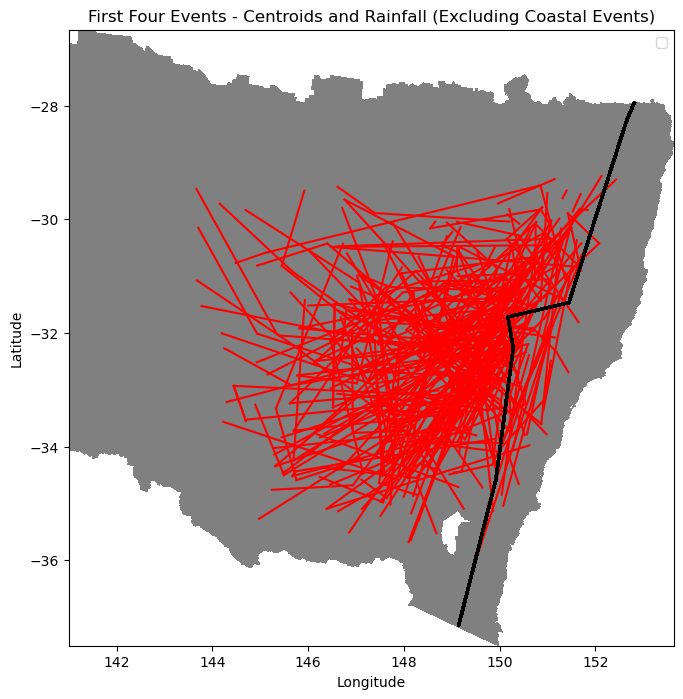

In [22]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde

# Define a minimum threshold for KDE values
kde_threshold = 1e-4

def plot_event_centroids(ax, csv_file, polygons_data, linestrings_data, xi, yi, positions, mask, event_label):
    try:
        # Load the CSV file
        df = pd.read_csv(csv_file)

        # Filter out NaN values in latitude and longitude
        x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

        # Sum up the rainfall values for the 7 days
        x_cleaned['7_day_accumulated_rainfall'] = x_cleaned[[col for col in x_cleaned.columns if col.startswith('Rainfall')]].sum(axis=1)

        # Perform Gaussian KDE on the accumulated rainfall data
        values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
        rainfall = x_cleaned['7_day_accumulated_rainfall']
        kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
        zi = kde(positions).reshape(xi.shape)

        # Mask the grid to include only points inside the polygons geometry
        zi = np.where(mask, zi, np.nan)

        # Plot the polygons and linestrings
        polygons_data.plot(ax=ax, color='gray', edgecolor='none')
        linestrings_data.plot(ax=ax, color='black', linewidth=2)  # Adjust color and linewidth as needed

        # Plot the 2D contour plot with accumulated rainfall as contours
        daily_means = []  # List to store daily mean rainfall
        centroids = []  # List to store retained centroids
        retained_days = []  # List to store retained days

        # Perform KDE for each day and calculate centroids based on threshold
        rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]
        colors = sns.color_palette("husl", len(rainfall_columns))

        for i, col in enumerate(rainfall_columns):
            daily_rainfall = x_cleaned[col]
            daily_mean_rainfall = daily_rainfall.mean()
            daily_means.append(daily_mean_rainfall)
            print(f"{event_label} - Day {i+1} Mean Rainfall: {daily_mean_rainfall:.2f} mm")

        # Calculate the median of the daily mean rainfall
        median_threshold = np.median(daily_means)
        print(f"{event_label} - Median Threshold: {median_threshold:.2f} mm")

        # Track centroids and joined lines
        all_centroids = []
        all_joined_lines = []
        joined_centroids = set()

        for i, col in enumerate(rainfall_columns):
            daily_rainfall = x_cleaned[col]
            daily_mean_rainfall = daily_means[i]

            if daily_mean_rainfall >= median_threshold:
                daily_kde = gaussian_kde(values, weights=daily_rainfall, bw_method='scott')
                daily_zi = daily_kde(positions).reshape(xi.shape)
                daily_zi = np.where(mask, daily_zi, np.nan)
                # Apply the threshold to filter out negligible KDE values
                daily_zi = np.where(daily_zi >= kde_threshold, daily_zi, np.nan)
                daily_contour = ax.contour(xi, yi, daily_zi, levels=1, colors=[colors[i]], linewidths=1.5)

                if daily_contour.collections:
                    paths = [c.get_paths() for c in daily_contour.collections]
                    for path in paths:
                        for p in path:
                            centroid = p.vertices.mean(axis=0)  # Calculate the centroid
                            all_centroids.append(centroid)
                            retained_days.append(i)

                for c in daily_contour.collections:
                    c.remove()  # Remove the contour lines

        if all_centroids:
            all_centroids = np.array(all_centroids)
            centroids_set = set(tuple(c) for c in all_centroids)
            joined_centroids = set()
            joined_lines = []

            for j in range(len(all_centroids)):
                centroid = all_centroids[j]
                ax.plot(centroid[0], centroid[1], marker='', markersize=8, color='red', linestyle='')
                joined_centroids.add(tuple(centroid))

                if j > 0 and retained_days[j] == retained_days[j - 1] + 1:
                    ax.plot([all_centroids[j - 1, 0], centroid[0]], [all_centroids[j - 1, 1], centroid[1]], color='red', linestyle='-', linewidth=1.5)
                    joined_lines.append((all_centroids[j - 1], centroid))

            unjoined_centroids = [c for c in all_centroids if tuple(c) not in joined_centroids]
            for centroid in unjoined_centroids:
                ax.plot(centroid[0], centroid[1], 'o', color='blue', markersize=8, label=f'{event_label} - Unjoined')

            return np.array(all_centroids), joined_lines
    except Exception as e:
        print(f"Error processing {csv_file}: {e}")
        return np.array([]), []

# Load the GeoPackage layers
gpkg_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_layers.gpkg'
polygons_data = gpd.read_file(gpkg_path, layer='polygons')  # Adjust layer name if necessary
linestrings_data = gpd.read_file(gpkg_path, layer='linestrings')  # Adjust layer name if necessary

# Get the bounds of the polygons
minx, miny, maxx, maxy = polygons_data.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Mask the grid to include only points inside the polygons geometry
points = np.vstack((xi.flatten(), yi.flatten())).T
mask = np.array([polygons_data.contains(Point(point)).any() for point in points])
mask = mask.reshape(xi.shape)

# Load the Excel file and extract unique event names
excel_file = '/Users/coolkarni/Desktop/OneDrive - The University of Melbourne/R1_99_New Events.xlsx'
df_events = pd.read_excel(excel_file, sheet_name='Sheet5')
event_names = df_events['Event'].dropna().unique()

# Load the Coastal Events Excel file and extract event names to exclude
coastal_events_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/BoM Station list 4.xlsx'
df_coastal = pd.read_excel(coastal_events_file, sheet_name='Coastal Events')
coastal_events = df_coastal['Coastal Events'].dropna().unique()

# Filter out the coastal events from the event names
filtered_event_names = [event for event in event_names if event not in coastal_events]

# Find the CSV files for each event
csv_dir = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/'
event_files = [os.path.join(csv_dir, f'{event}.csv') for event in filtered_event_names]

# Slice to include only the first four events
event_files = event_files[:-1]  # Changed to only the first four events

# Initialize a list to store the joined lines and centroids for each event
all_joined_lines = []
all_centroids = []

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
for event_file in event_files:
    event_label = os.path.basename(event_file).replace('.csv', '')
    centroids, joined_lines = plot_event_centroids(ax, event_file, polygons_data, linestrings_data, xi, yi, positions, mask, event_label)
    if centroids.size > 0:
        all_centroids.append({'event': event_label, 'centroids': centroids})
    if joined_lines:
        all_joined_lines.append({'event': event_label, 'joined_lines': joined_lines})

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('First Four Events - Centroids and Rainfall (Excluding Coastal Events)')
plt.legend()
plt.show()

# Load existing data if available
existing_joined_lines_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/joined_lines2.csv'
existing_centroids_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/centroids2.csv'

if os.path.exists(existing_joined_lines_file):
    df_existing_joined_lines = pd.read_csv(existing_joined_lines_file)
else:
    df_existing_joined_lines = pd.DataFrame(columns=['event', 'start_lon', 'start_lat', 'end_lon', 'end_lat'])

if os.path.exists(existing_centroids_file):
    df_existing_centroids = pd.read_csv(existing_centroids_file)
else:
    df_existing_centroids = pd.DataFrame(columns=['event', 'longitude', 'latitude'])

# Append new data to existing data
new_joined_lines_data = []
for item in all_joined_lines:
    event = item['event']
    for line in item['joined_lines']:
        new_joined_lines_data.append({'event': event, 'start_lon': line[0][0], 'start_lat': line[0][1], 'end_lon': line[1][0], 'end_lat': line[1][1]})

df_new_joined_lines = pd.DataFrame(new_joined_lines_data)
df_combined_joined_lines = pd.concat([df_existing_joined_lines, df_new_joined_lines], ignore_index=True)
df_combined_joined_lines.to_csv(existing_joined_lines_file, index=False)

new_centroids_data = []
for item in all_centroids:
    event = item['event']
    for centroid in item['centroids']:
        new_centroids_data.append({'event': event, 'longitude': centroid[0], 'latitude': centroid[1]})

df_new_centroids = pd.DataFrame(new_centroids_data)
df_combined_centroids = pd.concat([df_existing_centroids, df_new_centroids], ignore_index=True)
df_combined_centroids.to_csv(existing_centroids_file, index=False)


In [6]:
import pandas as pd

# Path to the CSV file
file_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/centroids_with_sections.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Extract unique event names and their section numbers
unique_events = df[['event', 'section']].drop_duplicates()

# Save the unique events and sections to a new CSV file
output_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/unique_events_with_sections.csv'
unique_events.to_csv(output_path, index=False)

print("Unique events and sections have been saved to the new CSV file.")


Unique events and sections have been saved to the new CSV file.
